In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper")
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "NanumSquareRound")
plt.rcParams["axes.unicode_minus"] = False

### 다항 특성

- 일반 식

$$ y= w \times x + b $$
$$ time = [1,2,3,4,5,6,7,8,9...n] $$
- $degree$   가 1 일 때
    - $y =  w \times time + b$
    - $X_{ploy} = [[1,0], [1,1], [1,2], [1,3], [1,4]...]$
- $degree$ 가 2 일 때
    - $y = w_0 \times time^2 + w_1 \times time + b$
    - $X_{ploy} = [[1,0,0], [1,1,1], [1,2,4], [1,3,9], [1,4,16]...]$
- $degree$ 가 n 일 때
    - $y = w_1 \times time^n + w_2 \times time^{n-1} ... \space w_n \times time + b$
    
    $$
    X_{ploy} = \begin{bmatrix}
    [1,0,0,0 ... , 0^n] \\ 
    [1,1,1,1 ... , 1^n] \\
    [1,2,4,8 ... , 2^n] \\
     ...
    \end{bmatrix}
    $$
    
    $$
    y(X_{ploy}) = \begin{bmatrix}
    1 & 0 & 0 & 0 & ... & 0^n \\ 
    1 & 1 & 1 & 1 & ... & 1^n \\
    1 & 2 & 4 & 8 & ... & 2^n \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots
    \end{bmatrix} \times \begin{bmatrix}
    w_0 \\ w_1\\ w_2\\ ... \\w_n
    \end{bmatrix} + b
    $$

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

X = pd.DataFrame(np.arange(0,100), columns=["time"])

def make_as_poly(X,degree):
    model_poly = PolynomialFeatures(degree=degree)
    X_poly = model_poly.fit_transform(X)
    return np.int64(X_poly)

for i in range(1,6):
    print(f"degree {i} 일때 3 번째:",make_as_poly(X, degree=i)[3])

degree 1 일때 3 번째: [1 3]
degree 2 일때 3 번째: [1 3 9]
degree 3 일때 3 번째: [ 1  3  9 27]
degree 4 일때 3 번째: [ 1  3  9 27 81]
degree 5 일때 3 번째: [  1   3   9  27  81 243]


### Moving Average Plots

- 선형 추세를 보여주는 이동 평균 플롯.
- 이동 추세 계산 방법 살펴보기<br>
`dataframe.rolling(window=5, center=True).mean()`

In [3]:
import yfinance as yf
import pandas as pd

# S&P 500 데이터 가져오기
snp_500 = yf.download('AAPL', start='2010-01-01', end='2020-12-31')

snp_500=pd.DataFrame(columns=[i[0] for i in snp_500.columns],
                     data=snp_500.values,
                     index=snp_500.index)

# Close 가격만 남기고 필요한 열만 선택
close_snp = snp_500[['Close']].reset_index()

# 데이터 확인
close_snp.head()

close_snp['Moving_Avg'] = close_snp['Close'].rolling(window=500, center=True).mean()

[*********************100%***********************]  1 of 1 completed


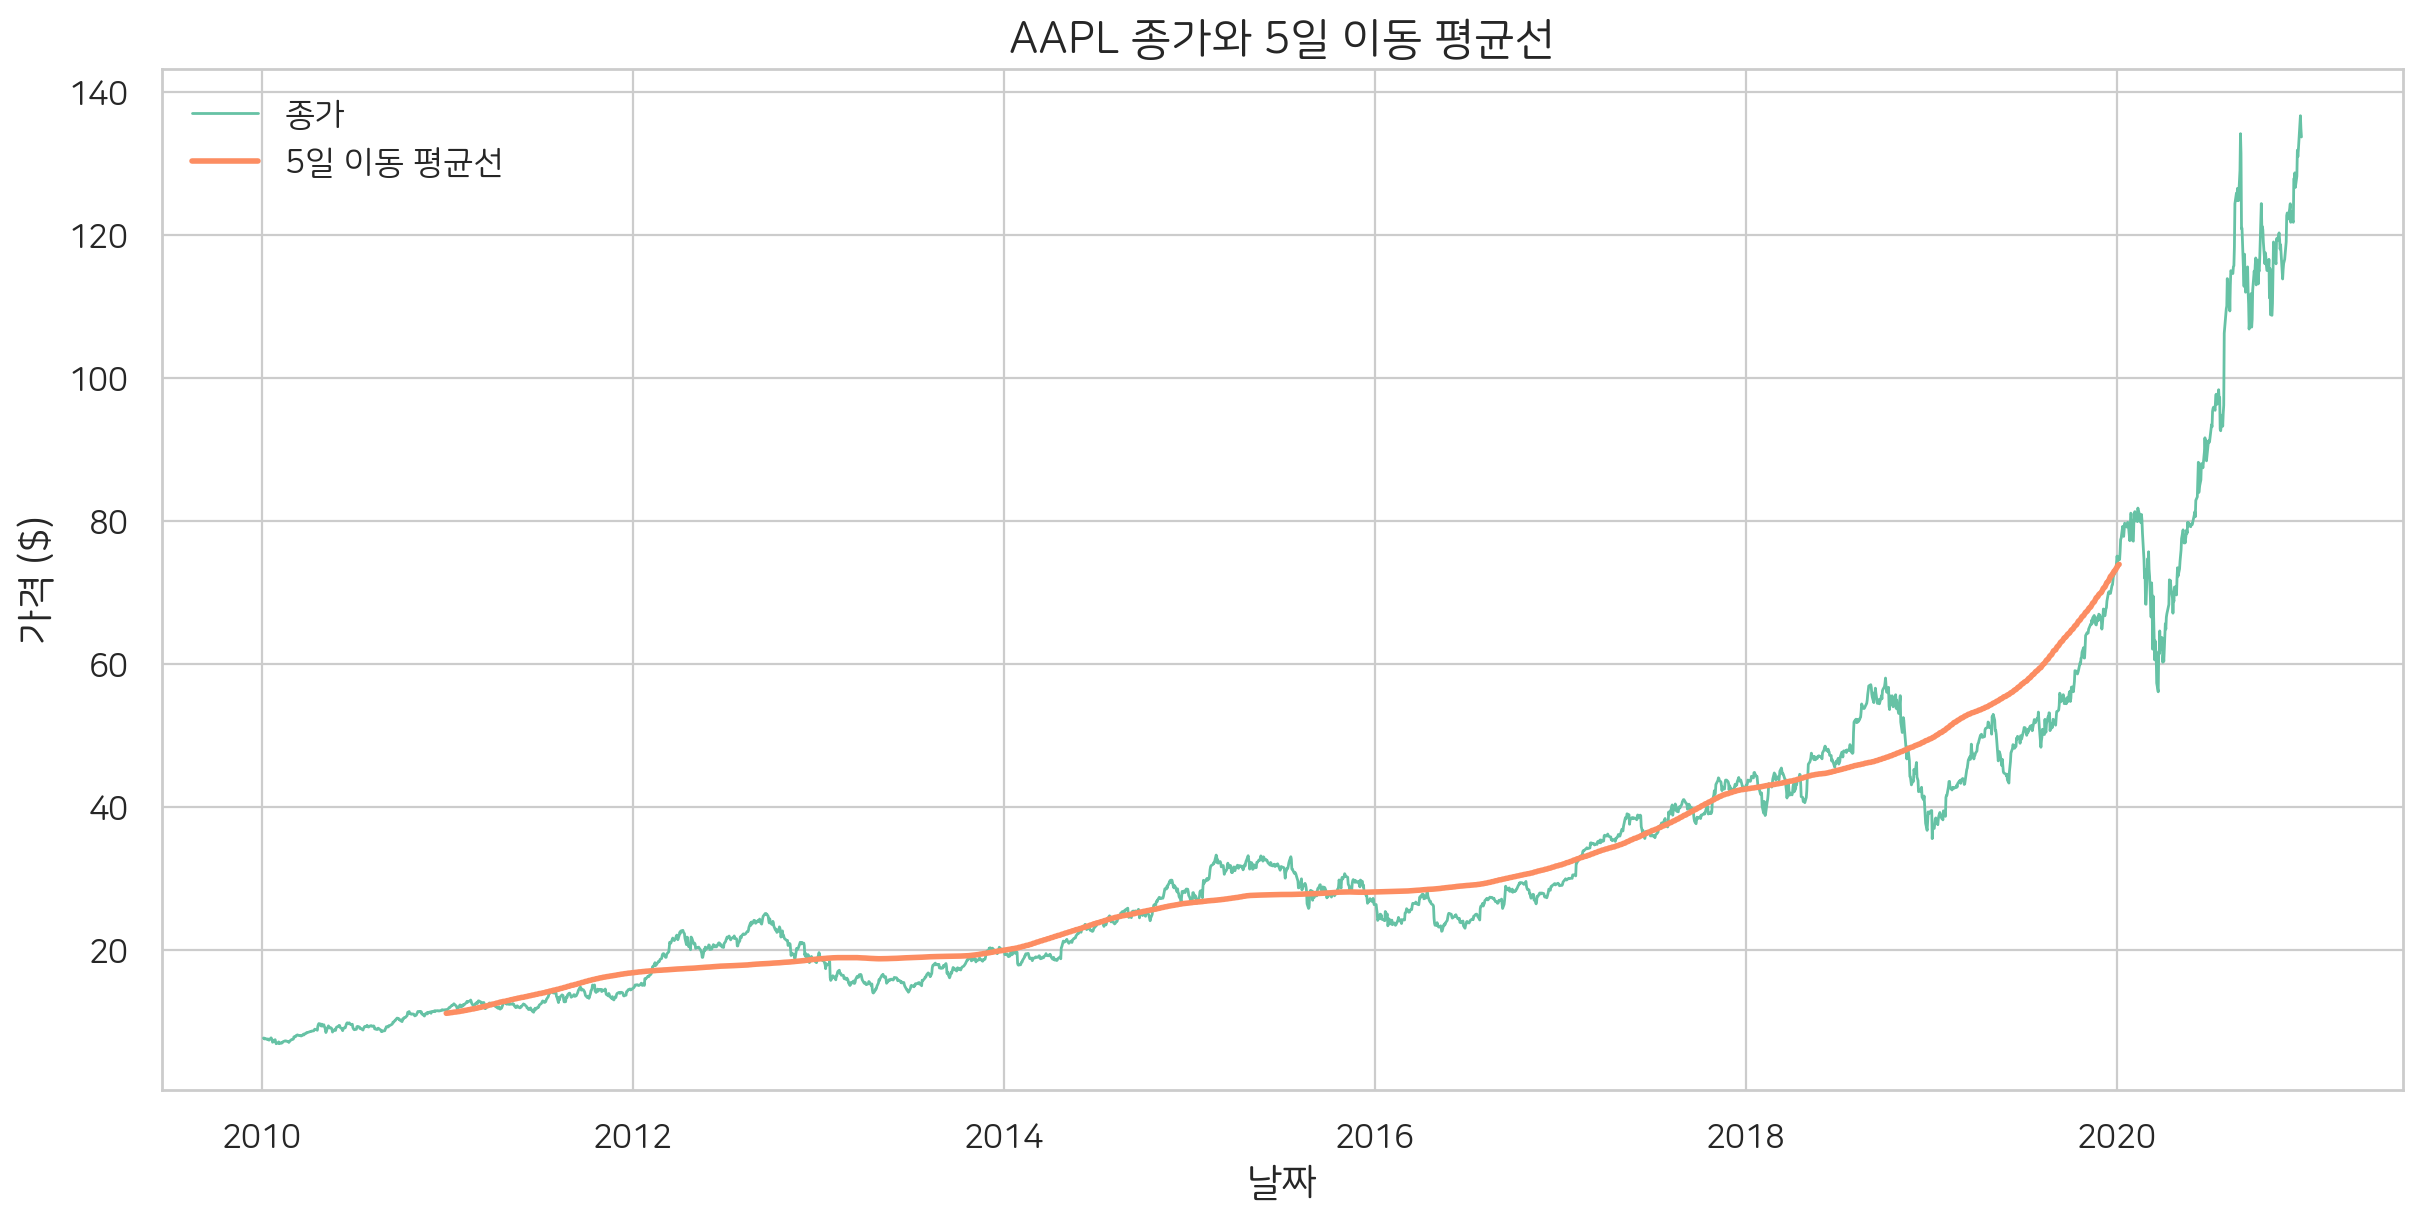

In [4]:
# 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 6))

# 종가 데이터
sns.lineplot(x=close_snp['Date'], 
             y=close_snp['Close'], 
             label="종가", 
             linewidth=1, ax=ax)

# 이동 평균선
sns.lineplot(x=close_snp['Date'], 
             y=close_snp['Moving_Avg'], 
             label="5일 이동 평균선", 
             linewidth=2, ax=ax)

# 제목과 축 레이블 설정
ax.set_title('AAPL 종가와 5일 이동 평균선', fontsize=16)
ax.set_xlabel('날짜', fontsize=14)
ax.set_ylabel('가격 ($)', fontsize=14)

# 범례 폰트 크기 설정
ax.legend(fontsize=12)

# 눈금 폰트 크기 설정
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

In [5]:
def drawing_graph(X,pt,xt,tt,xt2):
    fig, ax = plt.subplots(1,1, figsize=(12,6))

    sns.lineplot(data=X,
                 x = "Date",
                 y = "Close",
                 color="black",
                 label="실제 snp500 값",ax=ax)

    sns.lineplot(x=xt.index,
                 y=pt.flatten(),
                 color="tab:green",
                 alpha = 0.8,
                 linewidth = 3,
                 label="예측 데이터",ax=ax)
    sns.lineplot(x=xt2.index,
                 y=tt.flatten(),
                 alpha = 1,
                 color="tab:orange",
                 linewidth = 3,
                 label="예측 데이터",ax=ax)


### 트렌드 예측 (Trend, 추세)

- 추세는 장기적인 평균적인 움직임. 즉, 시계열 데이터의 장기적인 변화나 패턴.

- 선형 회귀 모델을 사용하여 트렌드를 학습하고 예측.
- 예측된 트렌드와 실제 데이터를 시각화하여 비교.

In [6]:
close_snp["index"] = close_snp.index
close_snp.set_index("Date", inplace=True)

- 다항 트렌드 피쳐 만들기 (DeterministicProcess)

In [146]:
y = close_snp[["Close"]]

# 다항 Trand 피쳐 만들기
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=False,      # drop terms to avoid collinearity
)

X = dp.in_sample()

In [147]:
X.tail()

,const,trend,trend_squared
Date,,,
2020-12-23 00:00:00+00:00,1.0,2764.0,7639696.0
2020-12-24 00:00:00+00:00,1.0,2765.0,7645225.0
2020-12-28 00:00:00+00:00,1.0,2766.0,7650756.0
2020-12-29 00:00:00+00:00,1.0,2767.0,7656289.0
2020-12-30 00:00:00+00:00,1.0,2768.0,7661824.0


In [148]:
x_train, x_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.4,
                                                    shuffle=False)

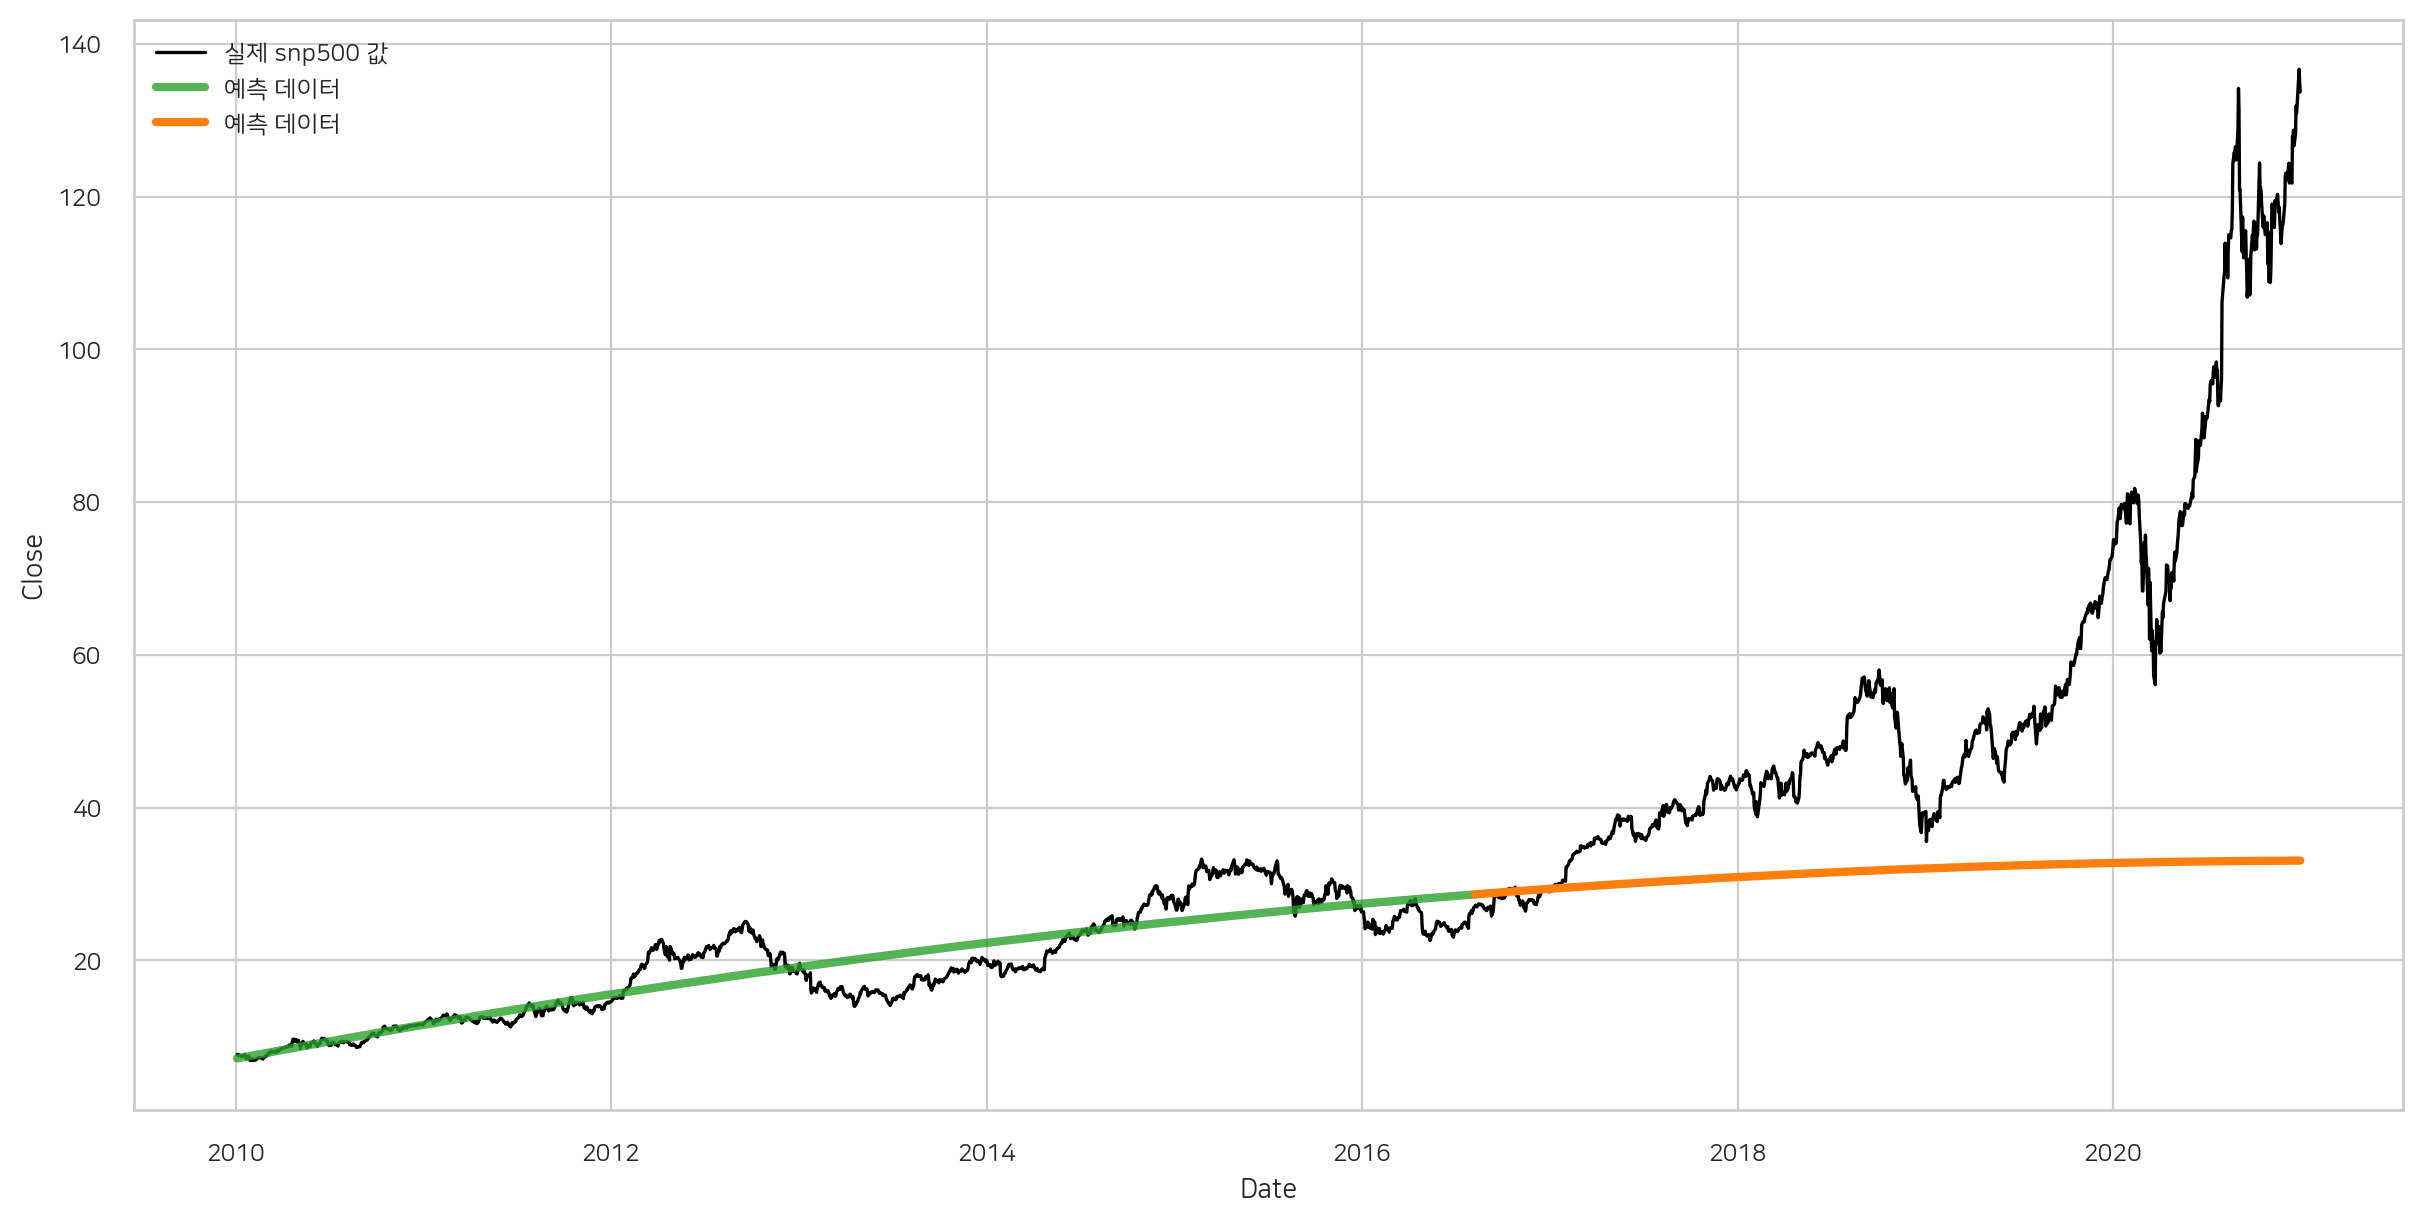

In [149]:
# 트렌드 학습하기
model_trend = LinearRegression()
model_trend.fit(x_train, y_train)
trend_pred_train = model_trend.predict(x_train)
trend_pred_test = model_trend.predict(x_test)
drawing_graph(snp_500,trend_pred_train,x_train,trend_pred_test,x_test)

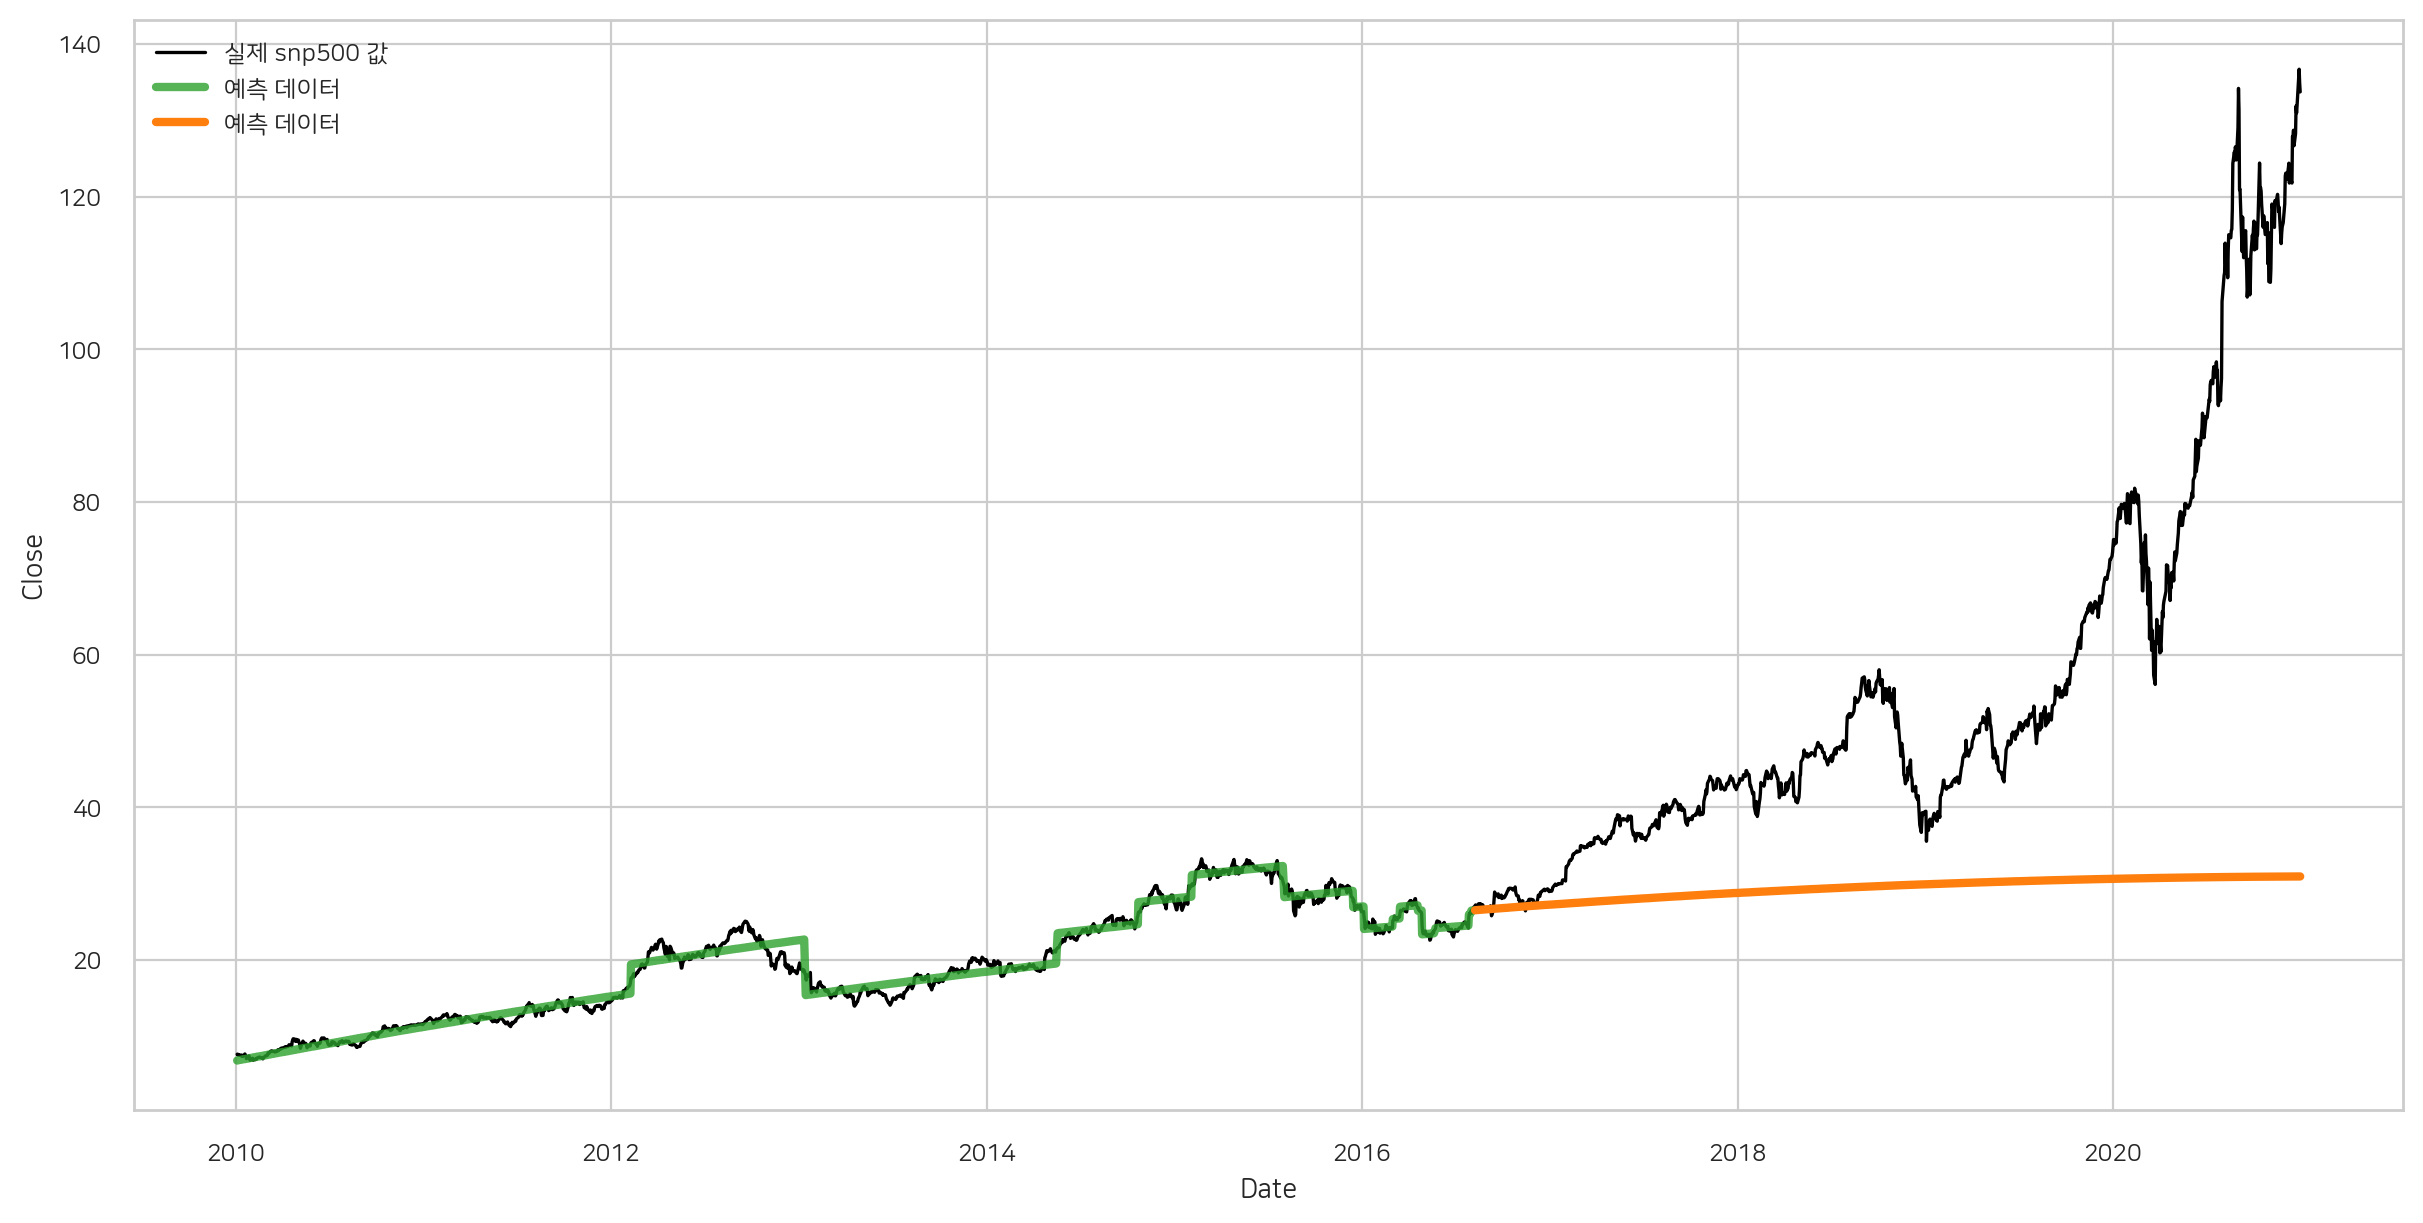

In [162]:
resid_train = y_train - trend_pred_train
model_tree = DecisionTreeRegressor(max_depth=4)
model_tree.fit(x_train,resid_train)
pred_fin_train = model_tree.predict(x_train) + trend_pred_train.reshape(len(x_train),)
pred_fin_test = model_tree.predict(x_test) + trend_pred_test.reshape(len(x_test),)

drawing_graph(snp_500,pred_fin_train,x_train,pred_fin_test,x_test)

In [151]:
close_snp

model_1 = LinearRegression()
model_1.fit(x_train, y_train)
pred_train = model_1.predict(x_train)
pred_test = model_1.predict(x_test)

In [152]:
pred_train = pd.Series(pred_train.flatten(), index=y_train.index)
pred_test = pd.Series(pred_test.flatten(), index=y_test.index)

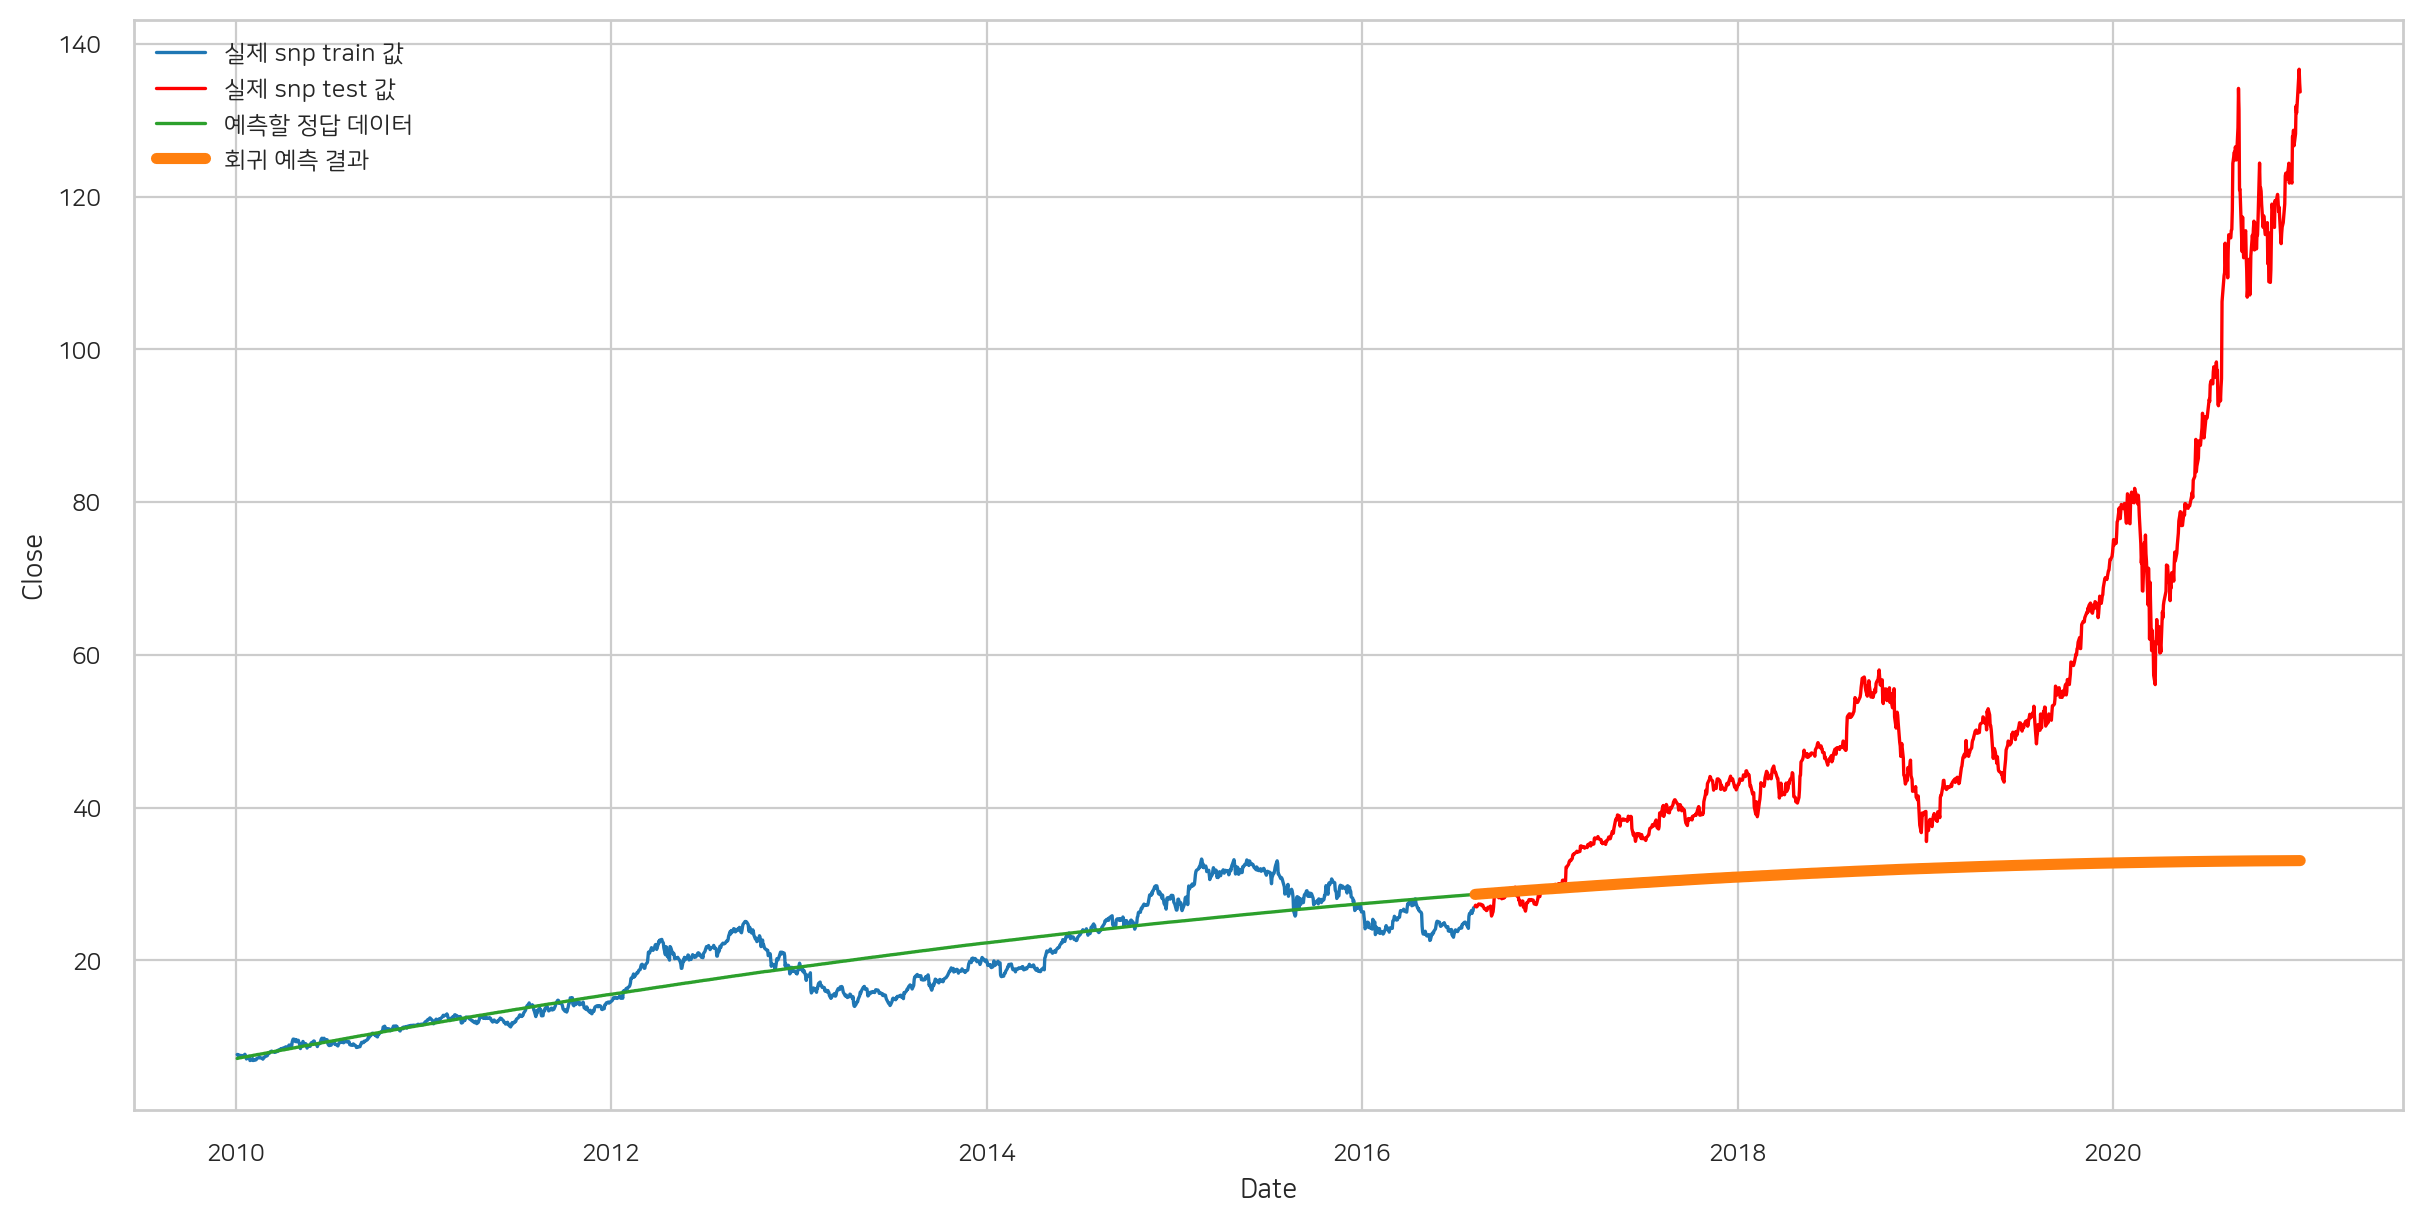

In [153]:
fig, ax = plt.subplots(1,1, figsize=(12,6))


sns.lineplot(data=y_train,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp train 값",)

sns.lineplot(data=y_test,
             x = "Date",
             y = "Close",
             color="red",
             label="실제 snp test 값",)

sns.lineplot(x=y_train.index,
             y=pred_train,
             color="tab:green",
             label="예측할 정답 데이터",)

sns.lineplot(x=y_test.index,
             y=pred_test,
             color="tab:orange",
             linewidth=4,
             label="회귀 예측 결과",);

In [154]:
model_2 = DecisionTreeRegressor(max_depth=2)
model_2.fit(x_train, y_train)
pred_train_2 = model_2.predict(x_train)
pred_test_2 = model_2.predict(x_test)

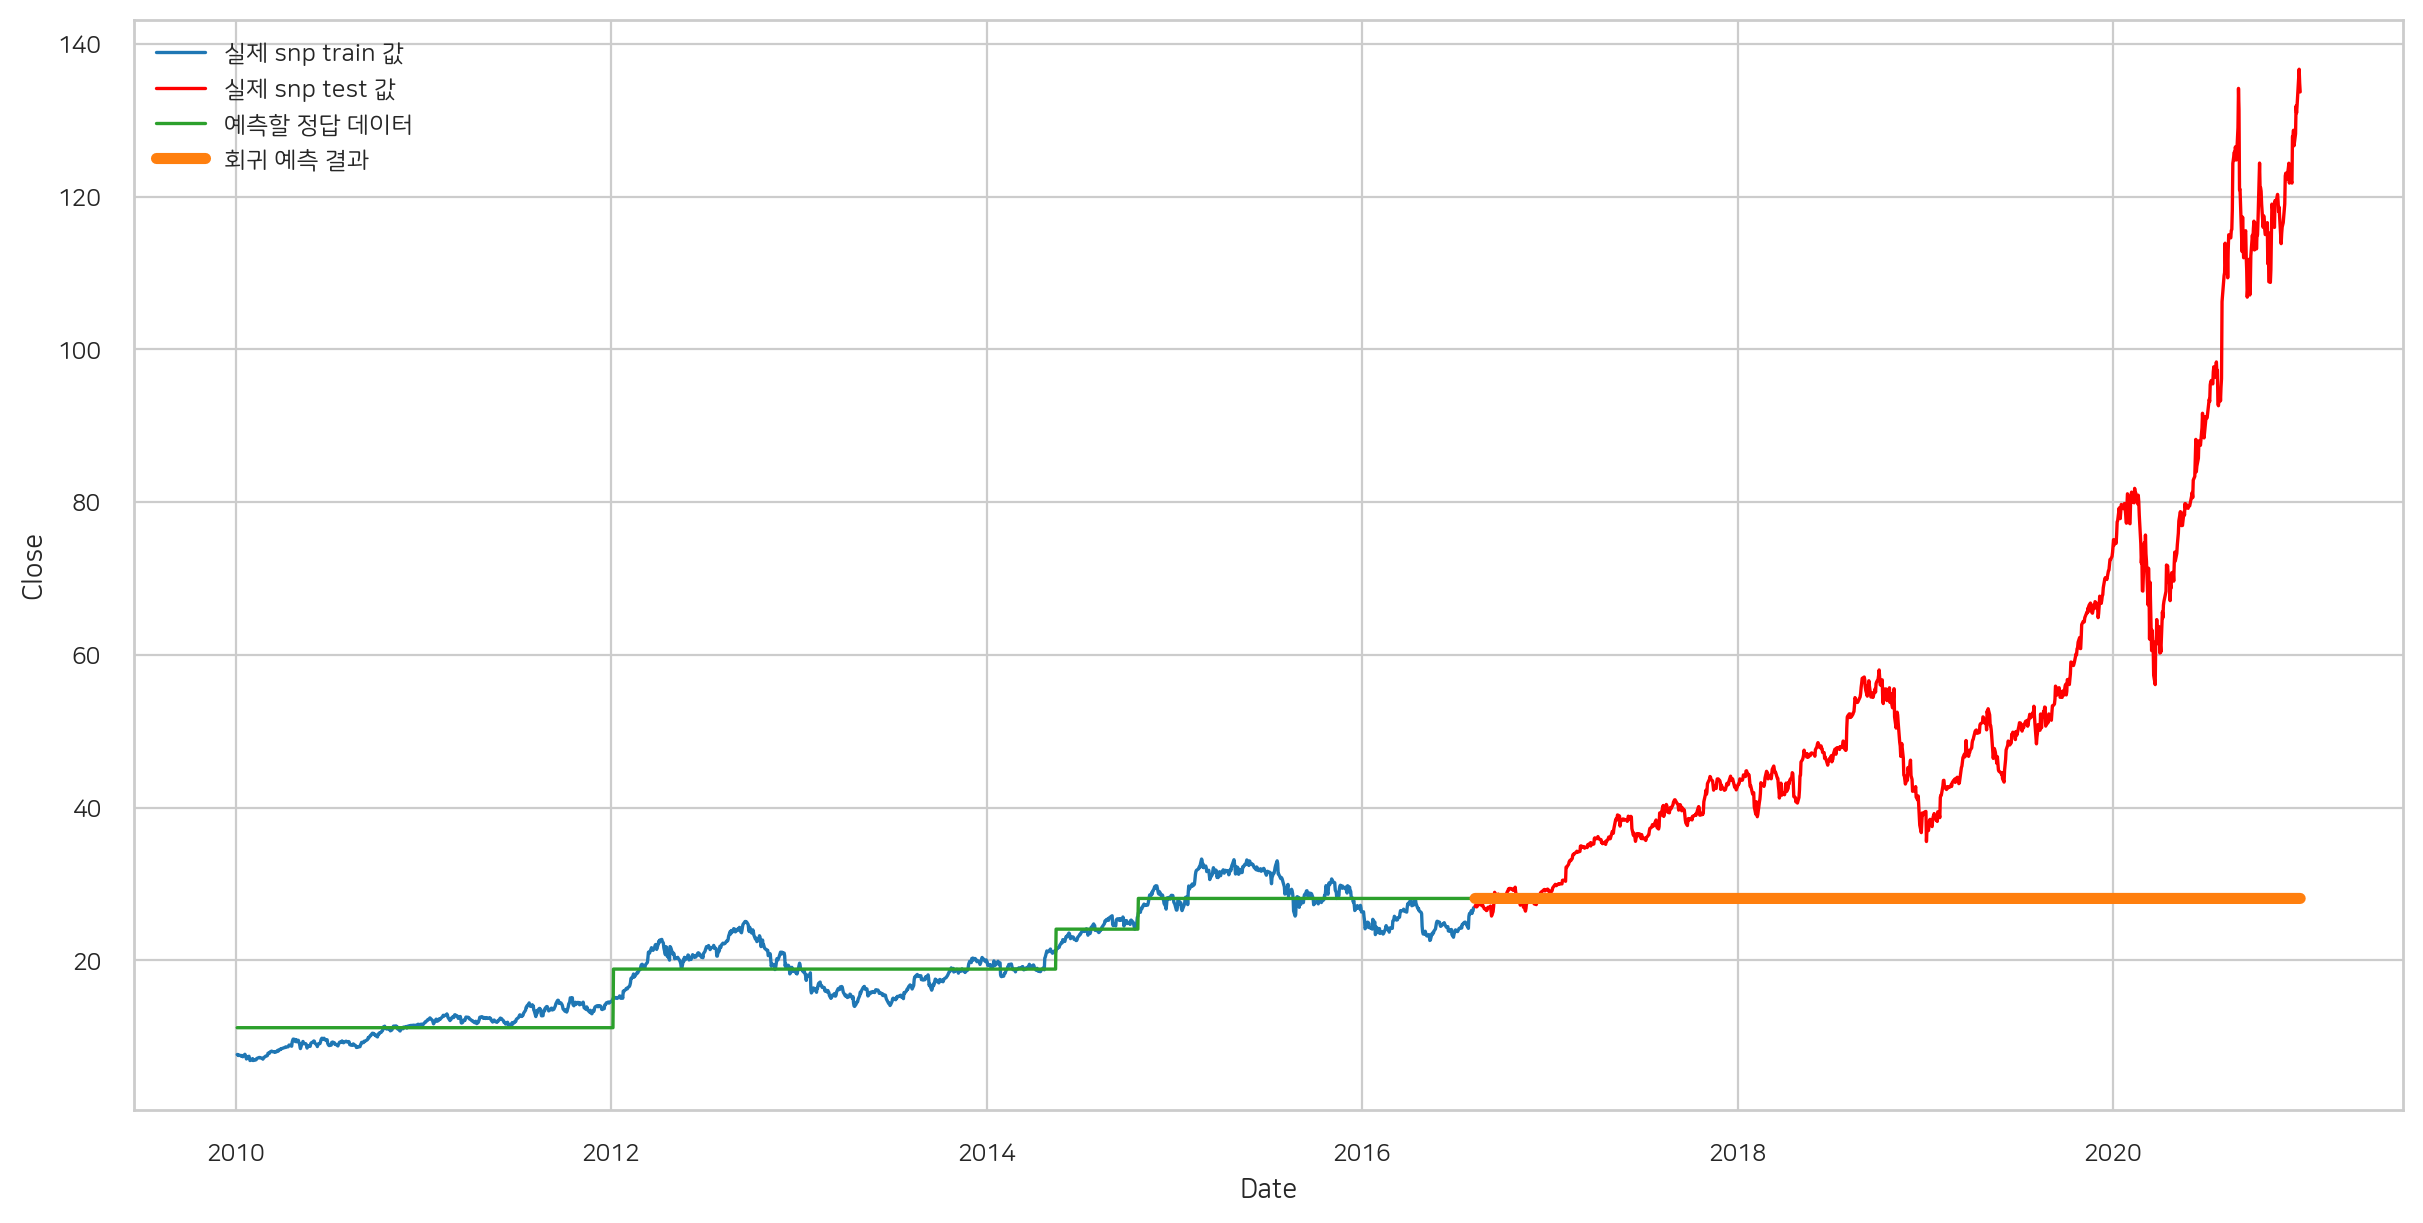

In [155]:
fig, ax = plt.subplots(1,1, figsize=(12,6))


sns.lineplot(data=y_train,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp train 값",)

sns.lineplot(data=y_test,
             x = "Date",
             y = "Close",
             color="red",
             label="실제 snp test 값",)

sns.lineplot(x=y_train.index,
             y=pred_train_2,
             color="tab:green",
             label="예측할 정답 데이터",)

sns.lineplot(x=y_test.index,
             y=pred_test_2,
             color="tab:orange",
             linewidth=4,
             label="회귀 예측 결과",);

### 잔차 모델링
- 트렌드 예측의 잔차를 모델링하기 위해 결정트리 회귀 모델을 사용하여 잔차를 예측.
- 초기 트렌드 예측과 잔차 예측 결과를 합쳐 최종 예측을 생성.
- 최종 예측 및 실제 데이터를 시각화하여 비교.

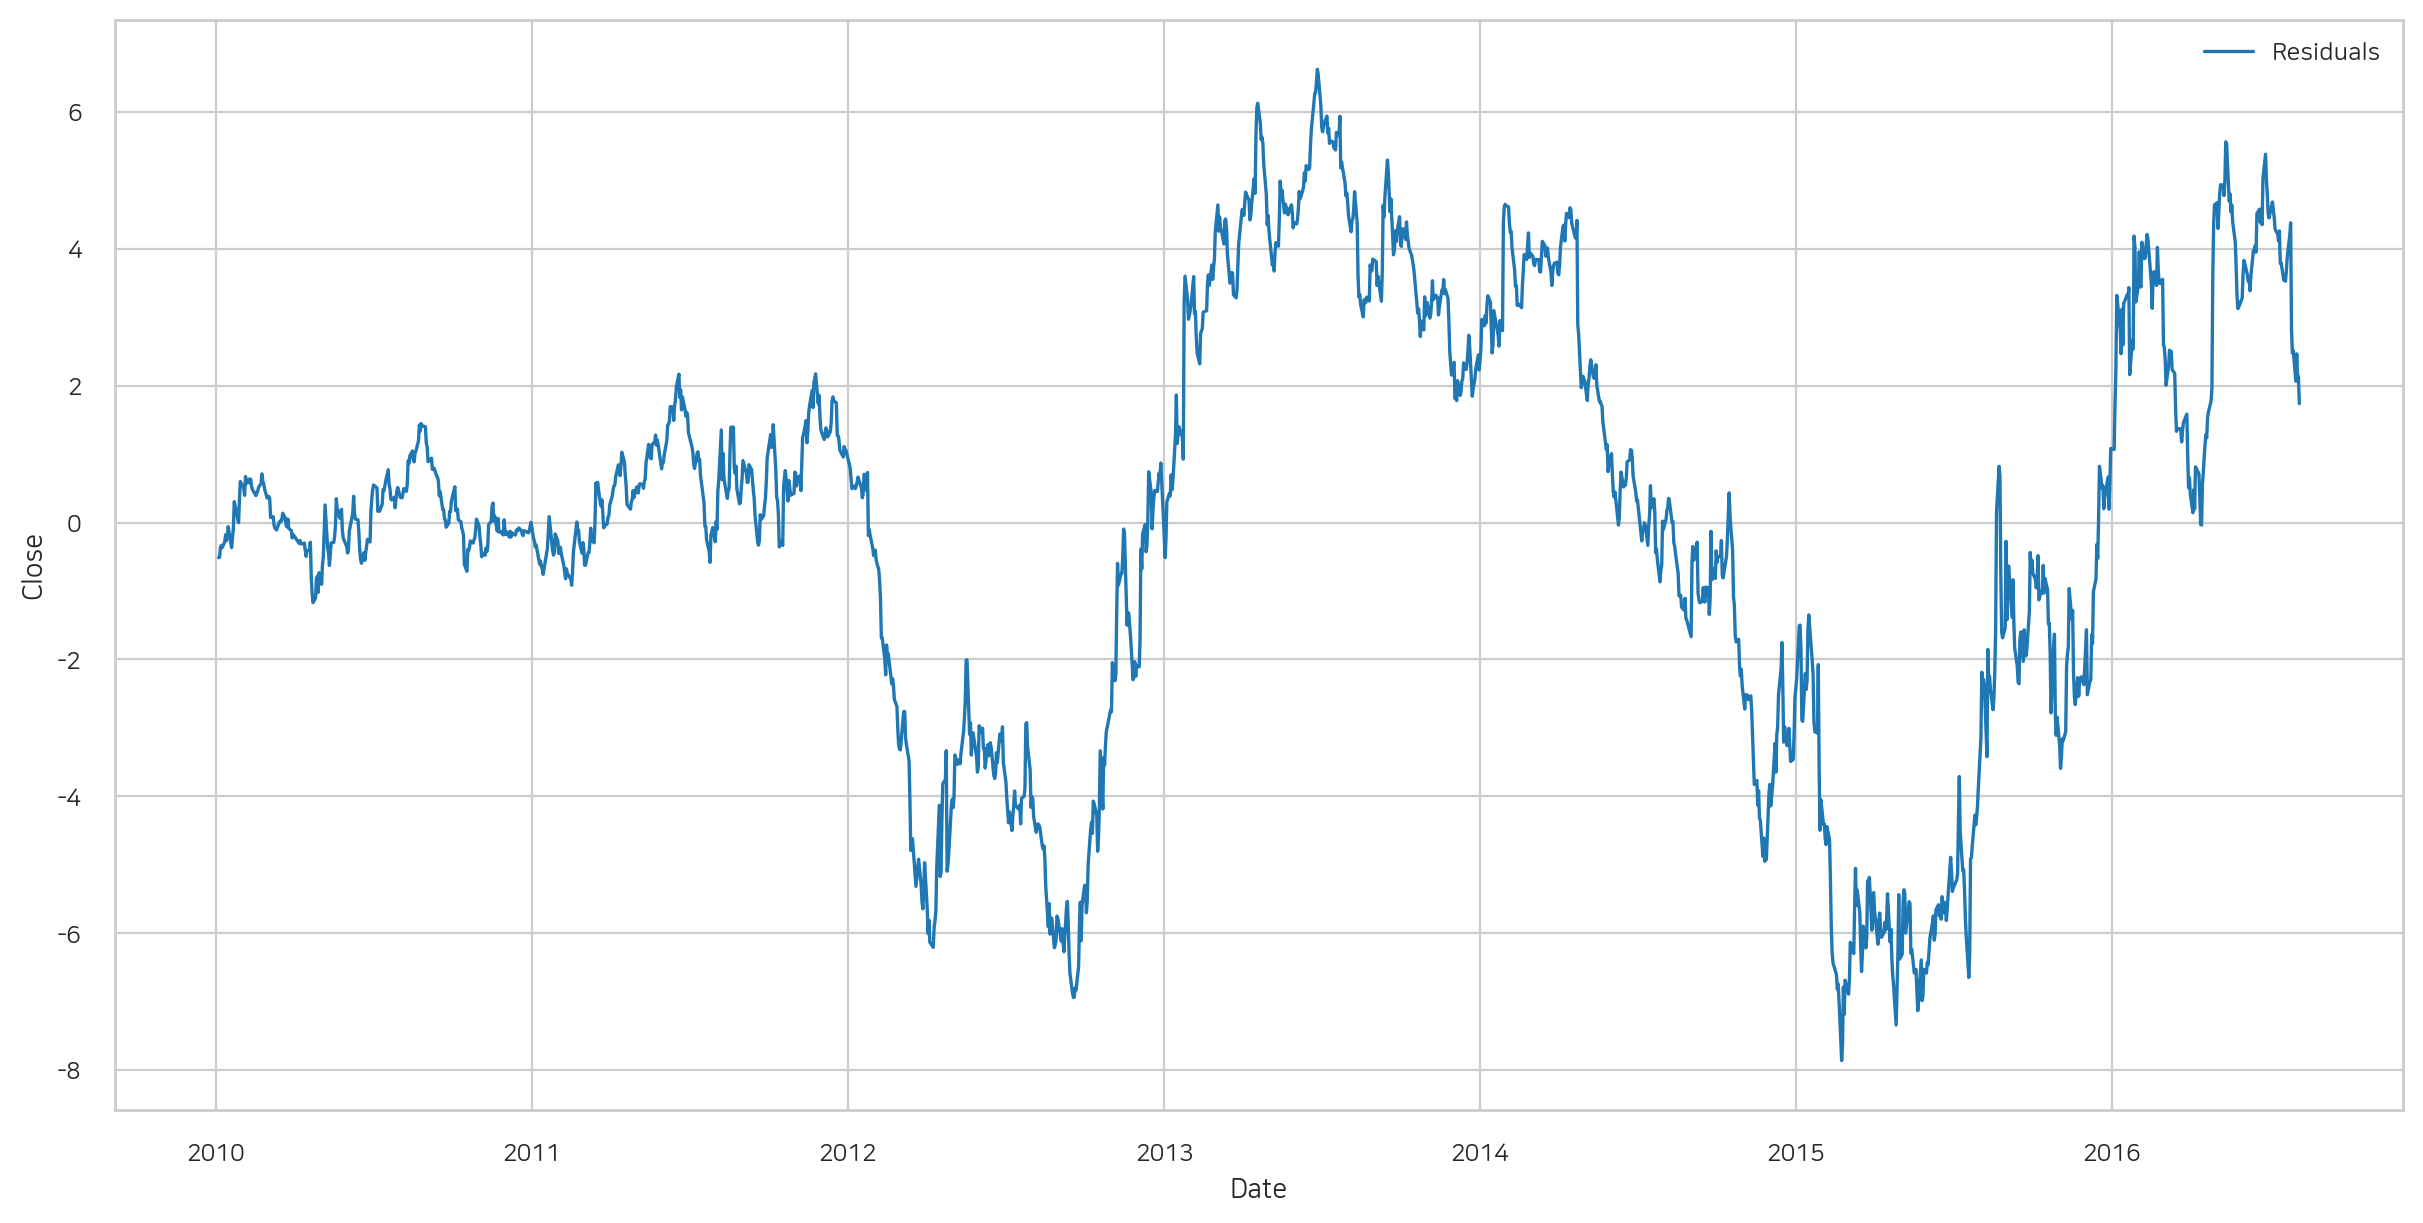

In [156]:
# 잔차 그래프 

resid = pd.DataFrame(data = pred_train.values,index = pred_train.index,columns= ["Close"]) - y_train

fig, ax = plt.subplots(1,1, figsize=(12,6))


sns.lineplot(data=resid,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="Residuals",);

In [157]:
resid.rename(columns={"Close":"resid"}, inplace=True)

In [158]:
model_3 = DecisionTreeRegressor()
model_3.fit(x_train.values,resid[["resid"]])

pred_test_3 = model_3.predict(x_test.values)
pred_train_3 = model_3.predict(x_train.values)



In [159]:
final_pred_train = pred_train - pred_train_3
final_pred_test = pred_test - pred_test_3

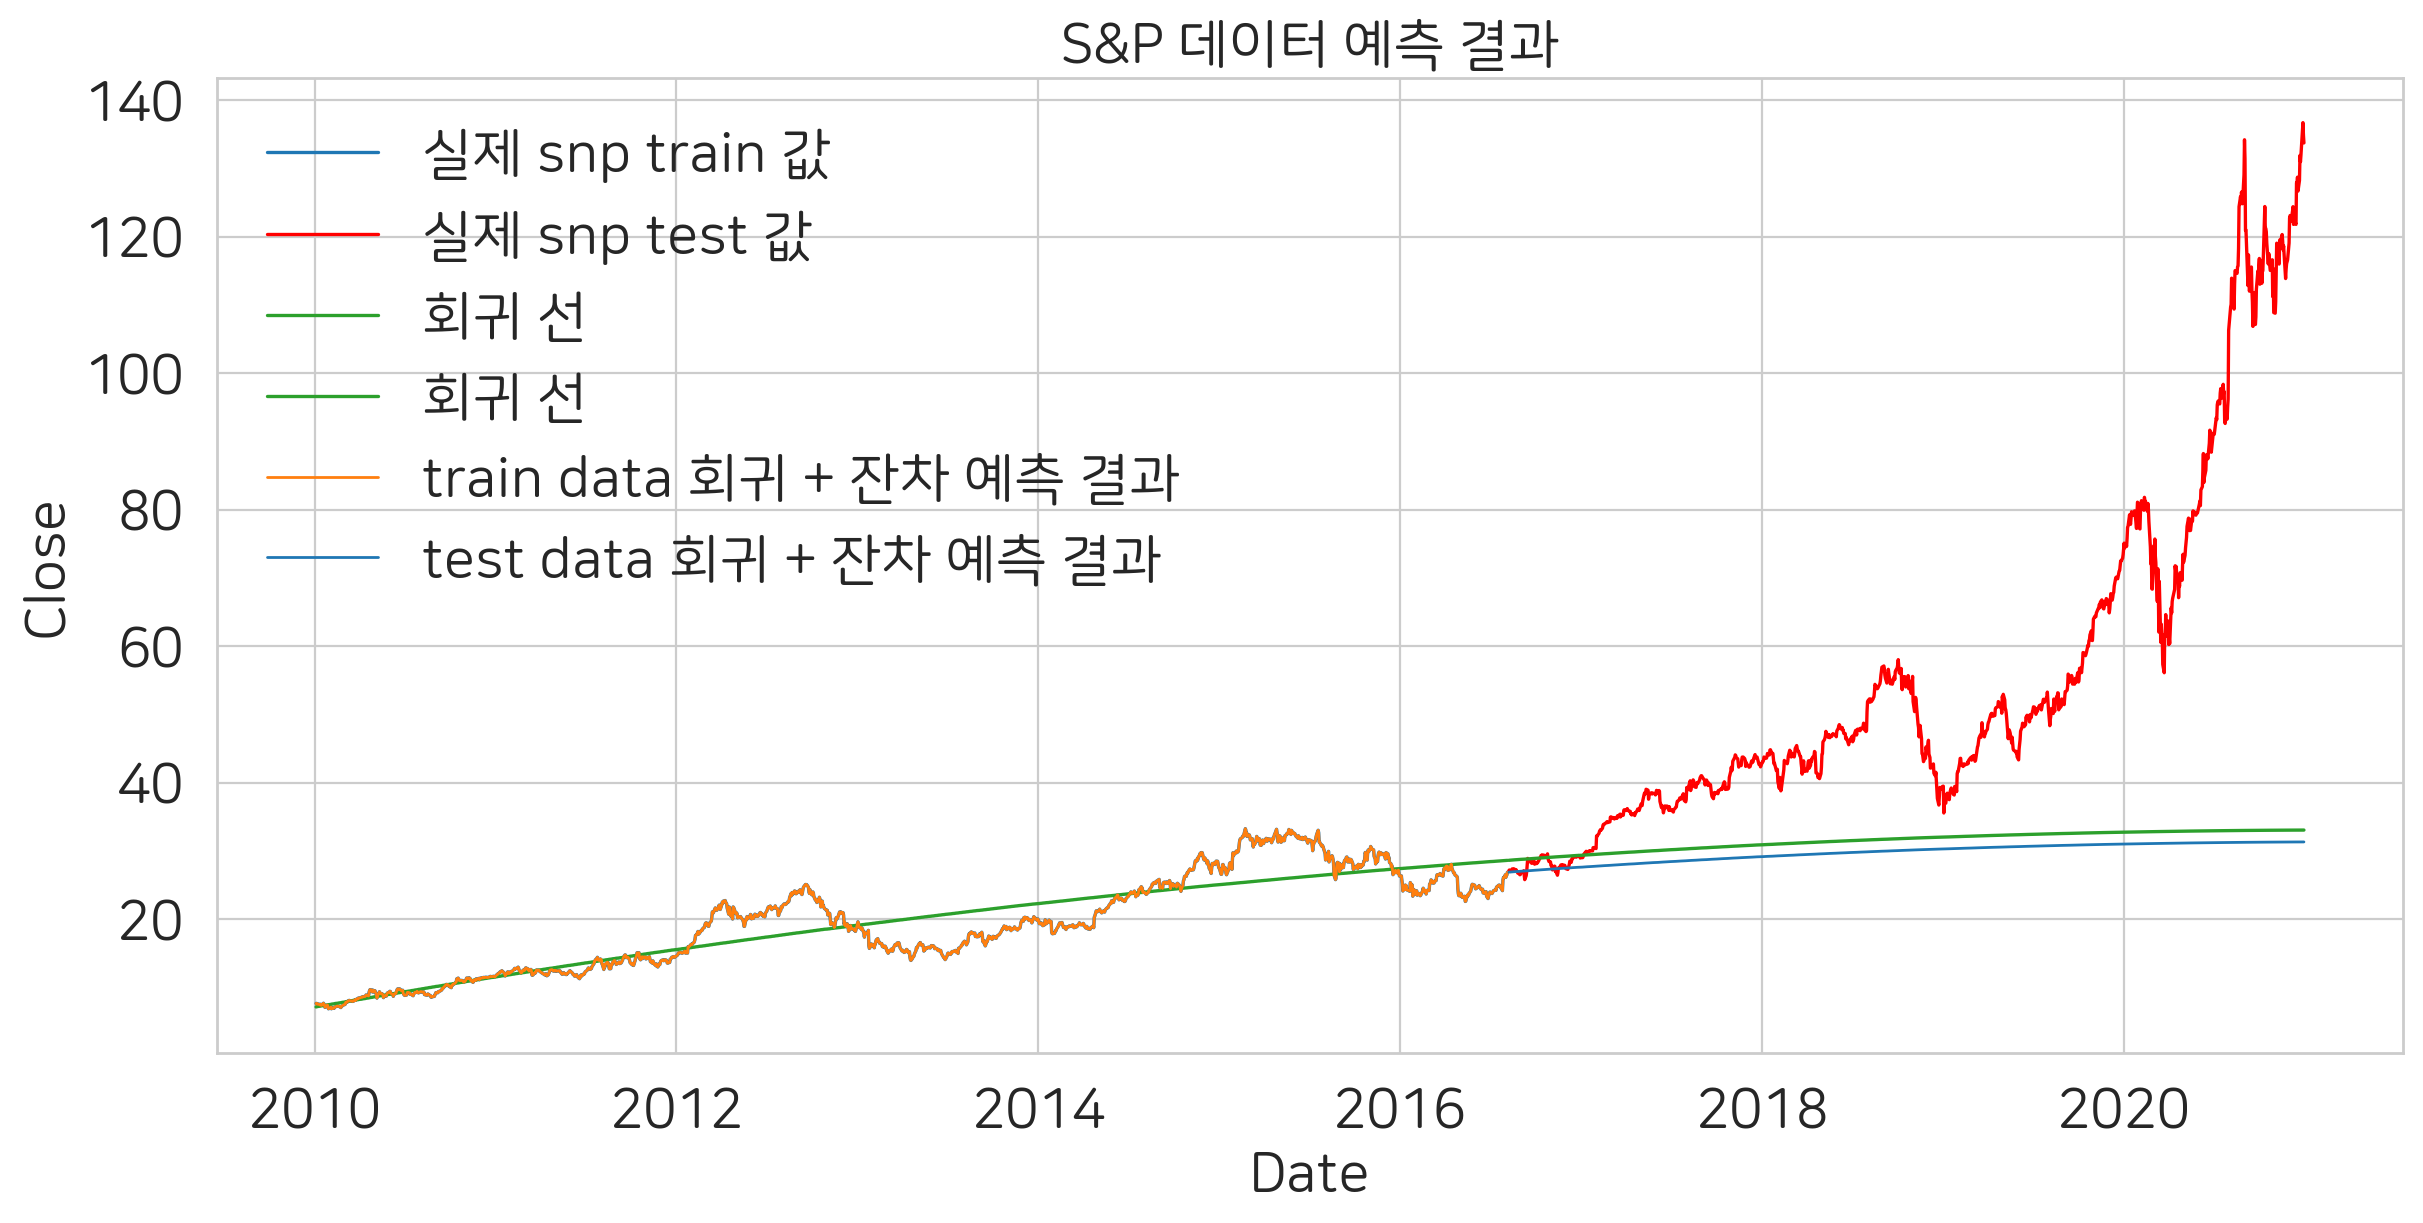

In [160]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1,1, figsize=(12,6))

sns.lineplot(data=y_train,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp train 값",)

sns.lineplot(data=y_test,
             x = "Date",
             y = "Close",
             color="red",
             label="실제 snp test 값",)

sns.lineplot(x=y_train.index,
             y=pred_train,
             color="tab:green",
             label="회귀 선",)

sns.lineplot(x=y_test.index,
             y=pred_test,
             color="tab:green",
             label="회귀 선",)

sns.lineplot(x=y_train.index,
             y=final_pred_train,
             color="tab:orange",
             linewidth=1,
             label="train data 회귀 + 잔차 예측 결과",);

sns.lineplot(x=y_test.index,
             y=final_pred_test,
             color="tab:blue",
             linewidth=1,
             label="test data 회귀 + 잔차 예측 결과",);

# 제목 폰트 크기
ax.set_title('S&P 데이터 예측 결과', fontsize=20)

# 축 레이블 폰트 크기
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Close', fontsize=20)

# 범례 폰트 크기
ax.legend(fontsize=20)

# 눈금 폰트 크기
ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()


### 성능 평가
- 여러 모델(선형 회귀, 결정트리)을 학습하고 예측했습니다. 각 모델의 성능을 시각화.
- 잔차를 별도로 모델링하고 이를 통해 최종 모델 성능을 분석.

### 지연 피쳐 및 이동 평균 생성
- 새로운 지연 피쳐와 이동 평균을 생성하고 이를 사용해 최종 예측 모델을 학습.
- 이전에 훈련된 모델의 지연 피쳐 및 이동 평균을 테스트 데이터에 적용하여 예측 결과를 시각화.

### 모델 시각화
- 각 단계마다 생성된 예측 결과 및 실제 값을 다양한 그래프로 시각화하여 분석.

이 과정은 시계열 데이터 예측의 전형적인 절차를 보여주며, 각 단계에서 시각화를 통해 모델의 성능을 직관적으로 확인할 수 있도록 돕는다.

In [161]:
# 1. 지연 피쳐 만들기
close_snp["Lag"]=  close_snp["Close"].shift(1)

# 2. 이동 평균
close_snp["moving_mean"]=close_snp["Close"].rolling(window=5,center=False).mean()

# 3. Serial Dependence
close_snp["index"] = close_snp.index - close_snp.index.min() - 2 # 결측치를 없애기 위함

close_snp.index = close_snp["Date"]
close_snp.drop(columns=["Date"], inplace=True)
close_snp_prep = close_snp.dropna(axis=0)


TypeError: Addition/subtraction of integers and integer-arrays with TimedeltaArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [ ]:
X = close_snp_prep.drop(columns=["Close"])
y = close_snp_prep[["Close"]]

x_train, x_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 30,
                                                    random_state = 42,
                                                    shuffle=False)

In [ ]:
# 테스트 데이터의 lag, moving_mean 을 모른다는 가정하에 우선 lag 훈련 시키기
# 입력값 index, 라벨 값 = lag
lag_regress = LinearRegression()
lag_regress.fit(x_train[["index"]],x_train[["Lag"]])
lag_pred_test = lag_regress.predict(x_test[["index"]])


In [ ]:
x_test["Lag"] = pd.DataFrame(data=lag_pred_test.flatten(),index=x_test.index,columns=["Lag"])
x_test

,Lag,moving_mean,index
Date,,,
2020-09-24,3199.321917,3279.922022,268
2020-09-25,3200.172048,3275.720020,269
2020-09-28,3201.022179,3289.828027,270
2020-09-29,3201.872309,3293.808008,271
2020-09-30,3202.722440,3319.024024,272
2020-10-01,3203.572571,3345.866016,273
2020-10-02,3204.422702,3355.858008,274
2020-10-05,3205.272833,3367.258008,275
2020-10-06,3206.122964,3372.358008,276


In [ ]:
x_test["moving_mean"] = x_test["Lag"].rolling(window=5, center=False).mean()
x_test.dropna(axis=0, inplace=True)

In [ ]:
x_test

,Lag,moving_mean,index
Date,,,
2020-09-30,3202.722440,3201.022179,272
2020-10-01,3203.572571,3201.872309,273
2020-10-02,3204.422702,3202.722440,274
2020-10-05,3205.272833,3203.572571,275
2020-10-06,3206.122964,3204.422702,276
2020-10-07,3206.973095,3205.272833,277
2020-10-08,3207.823226,3206.122964,278
2020-10-09,3208.673357,3206.973095,279
2020-10-12,3209.523488,3207.823226,280


In [ ]:
# 예측한 지연 피쳐에 대한이동 평균 계산


In [ ]:
model_final_1 = LinearRegression()
model_final_1.fit(x_train, y_train)
pred_train_final_1 = model_final_1.predict(x_train)
pred_test_final_1 = model_final_1.predict(x_test)

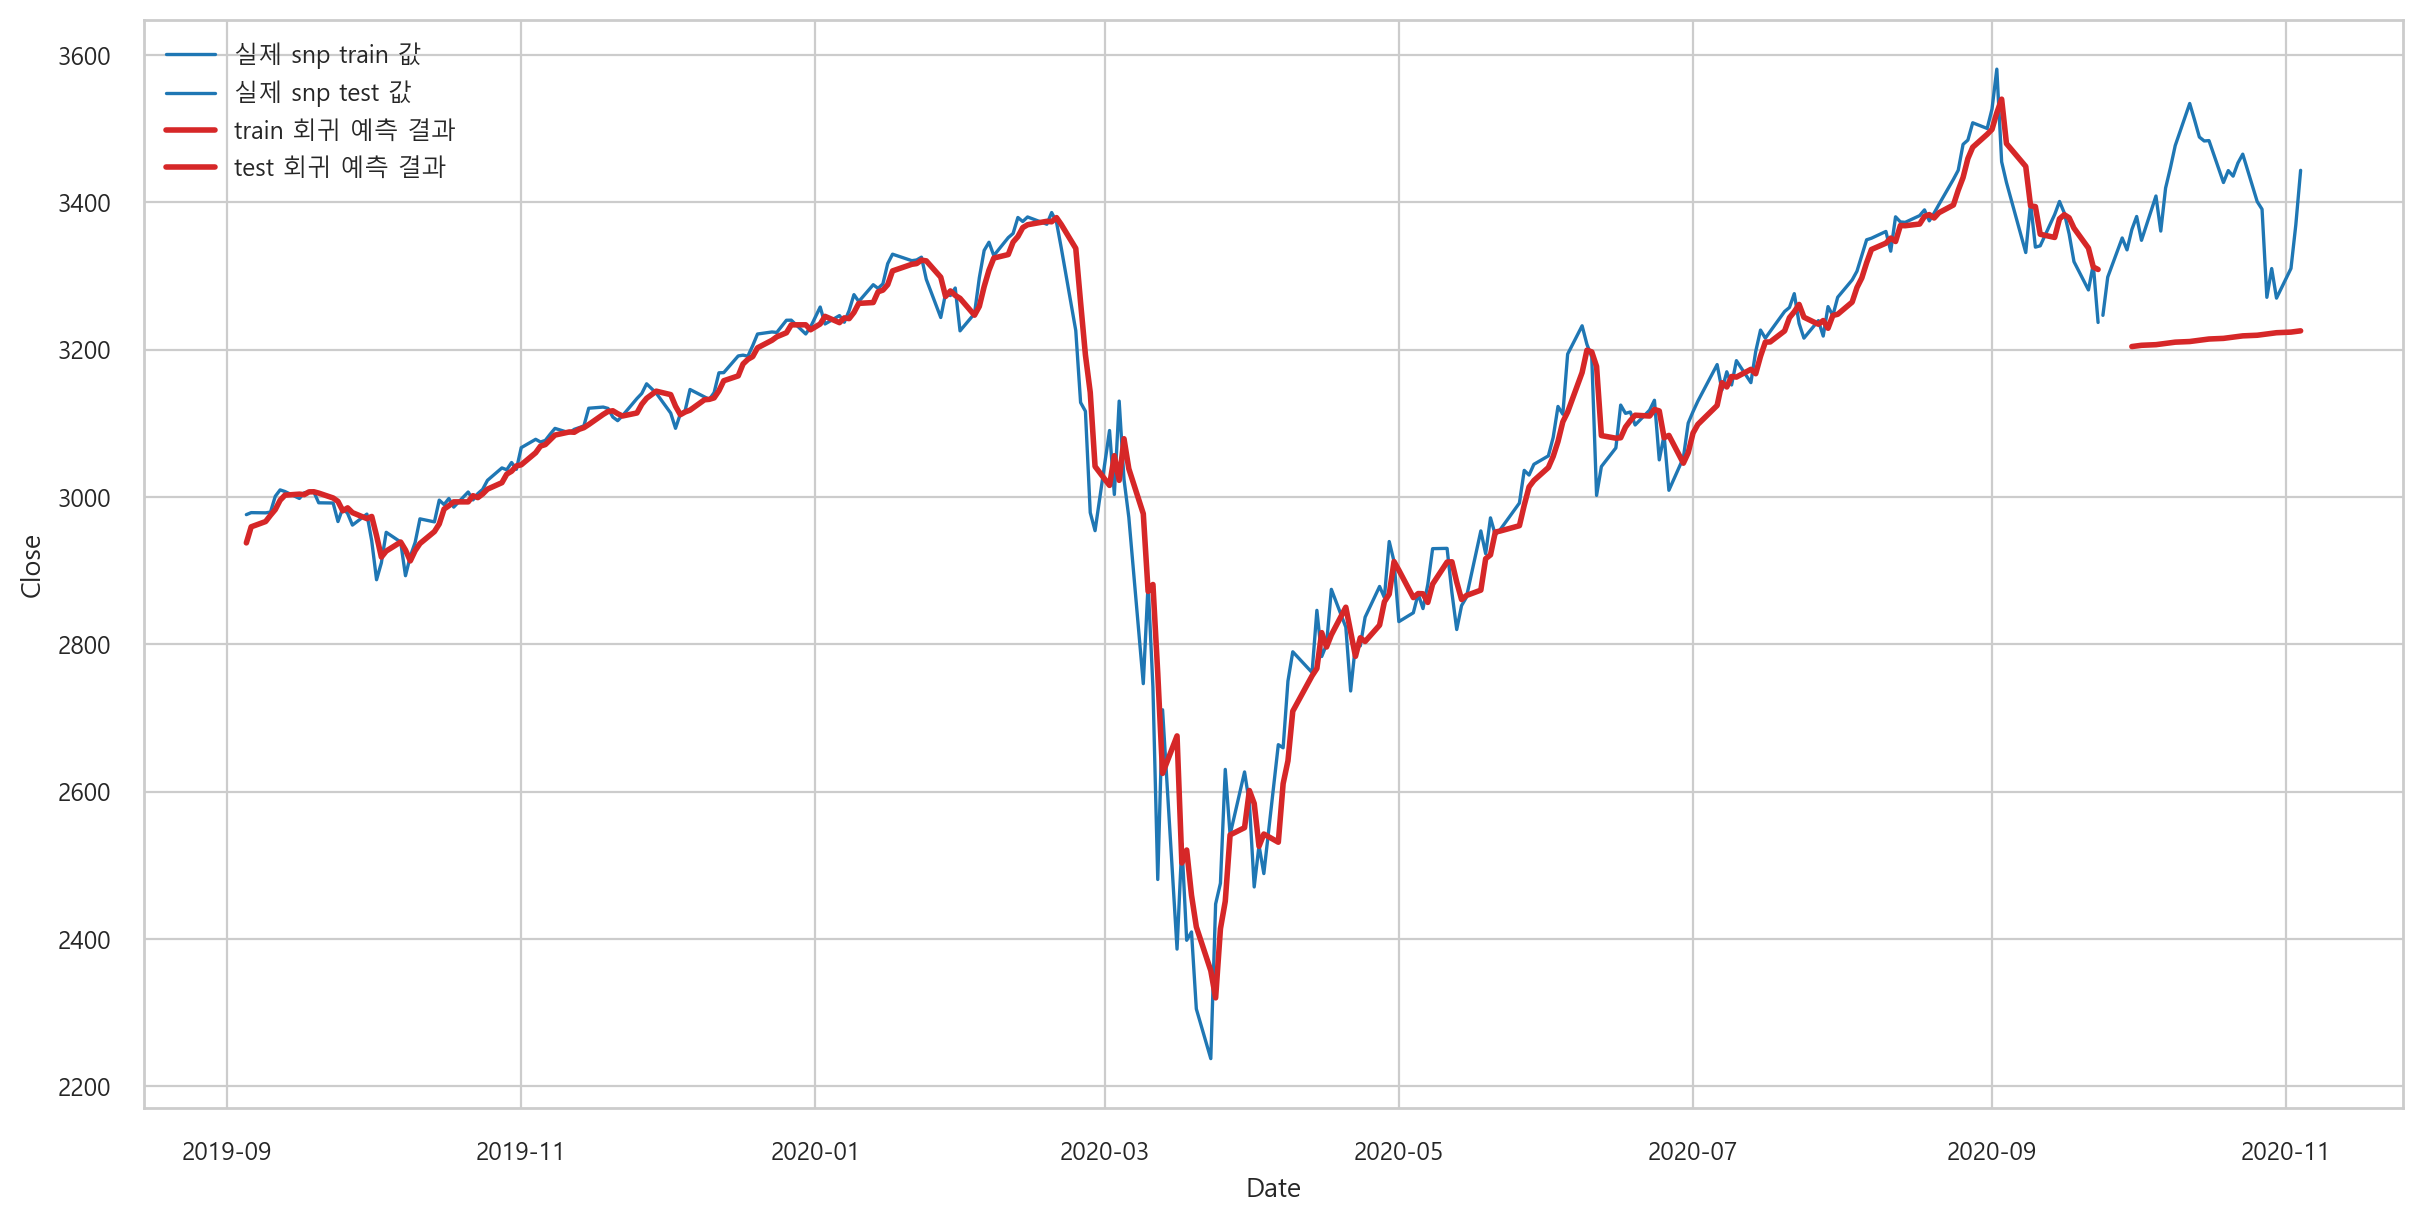

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6))


sns.lineplot(data=y_train,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp train 값",)

sns.lineplot(data=y_test,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp test 값",)

sns.lineplot(x=y_train.index,
             y=pred_train_final_1.flatten(),
             color="tab:red",
             linewidth=2,
             label="train 회귀 예측 결과",);

sns.lineplot(x=x_test.index,
             y=pred_test_final_1.flatten(),
             color="tab:red",
             linewidth=2,
             label="test 회귀 예측 결과",);

### example

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

### 함수정의

In [163]:
from sklearn.preprocessing import PolynomialFeatures

def make_as_poly(X,degree):
    model_poly = PolynomialFeatures(degree=degree)
    X_poly = model_poly.fit_transform(X)
    return np.int64(X_poly)



### 전처리

,time
Date,
1927-12,0
1928-01,1
1928-02,2
1928-03,3
1928-04,4
...,...
2020-07,1111
2020-08,1112
2020-09,1113


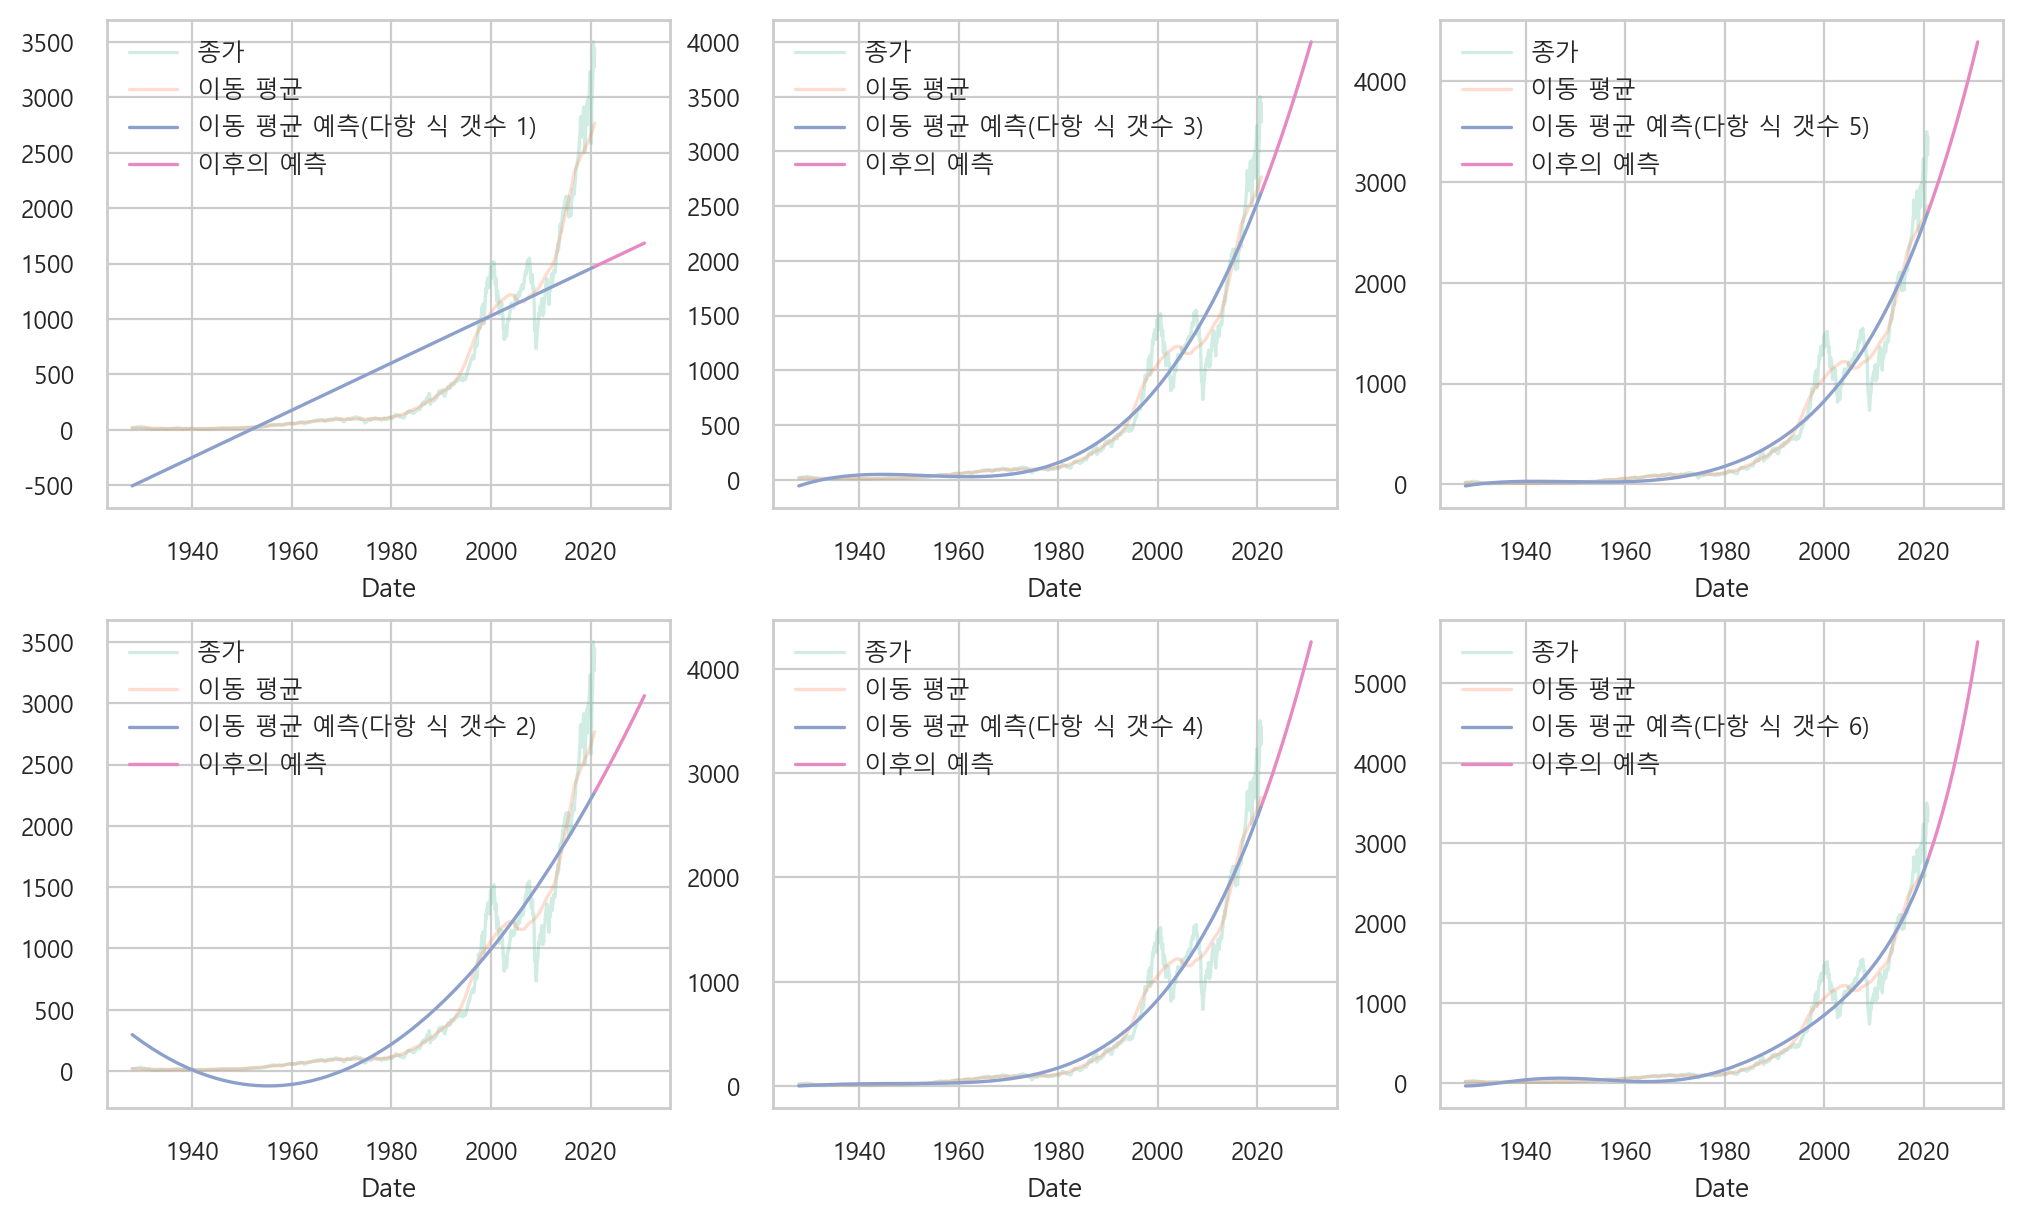

In [ ]:
from sklearn.linear_model import LinearRegression

# 데이터 불러오기
snp_500 = pd.read_csv('../datas/study_data/snp500_history.csv',
                      index_col='Date',
                      parse_dates=['Date'])

# 월말 데이터로 리샘플링
snp_500_month_end = snp_500.resample('M').last()

# 인덱스를 기간으로 변환
snp_500_month_end.index = snp_500_month_end.index.to_period('M')
snp_500_month_end['time'] = np.arange(len(snp_500_month_end.index))

# 이동 평균 구하기
trend_500 = snp_500_month_end["Adj Close"]
trend_500_trend = trend_500.rolling(window=100, center=True, min_periods=6).mean()

# 데이터 준비
X = pd.DataFrame(snp_500_month_end["time"])
y = trend_500_trend

# 다항 특성 생성
X_poly = make_as_poly(X, degree=2)

fig, ax = plt.subplots(2,3,figsize=(10,6))
ind_list = [[j,k] for k in range(3) for j in range(2)]

dict_date_afterword = {}
for i in range(1, 121): # 추가로 10년간 데이터
    dict_date_afterword[X.index[-1] + i] = int(X.iloc[-1]) + i

df_after = pd.DataFrame(data=dict_date_afterword.values(),
                        index=dict_date_afterword.keys(),
                        columns=["time"])

for i in range(1,7):
    model = LinearRegression()
    model.fit(make_as_poly(X,i), y)
    pred = model.predict(make_as_poly(X,i))
    pred_after = model.predict(make_as_poly(df_after,i))

    r = ind_list[i-1][0]
    c = ind_list[i-1][1]
    

    sns.lineplot(x = trend_500.index.astype("datetime64"),
                 y = trend_500.values,
                 alpha = 0.3,
                 label = "종가",
                 ax=ax[r][c])
    sns.lineplot(x = trend_500.index.astype("datetime64"),
                 y = trend_500_trend.values,
                 alpha = 0.3,
                 label = "이동 평균",
                 ax=ax[r][c])
    sns.lineplot(x = trend_500.index.astype("datetime64"),
                y = pred,
                label=f'이동 평균 예측(다항 식 갯수 {i})',
                ax=ax[r][c])
    sns.lineplot(x = df_after.index.astype("datetime64"),
                y = pred_after,
                label=f'이후의 예측',
                ax=ax[r][c])
    
X

<AxesSubplot: xlabel='Date'>

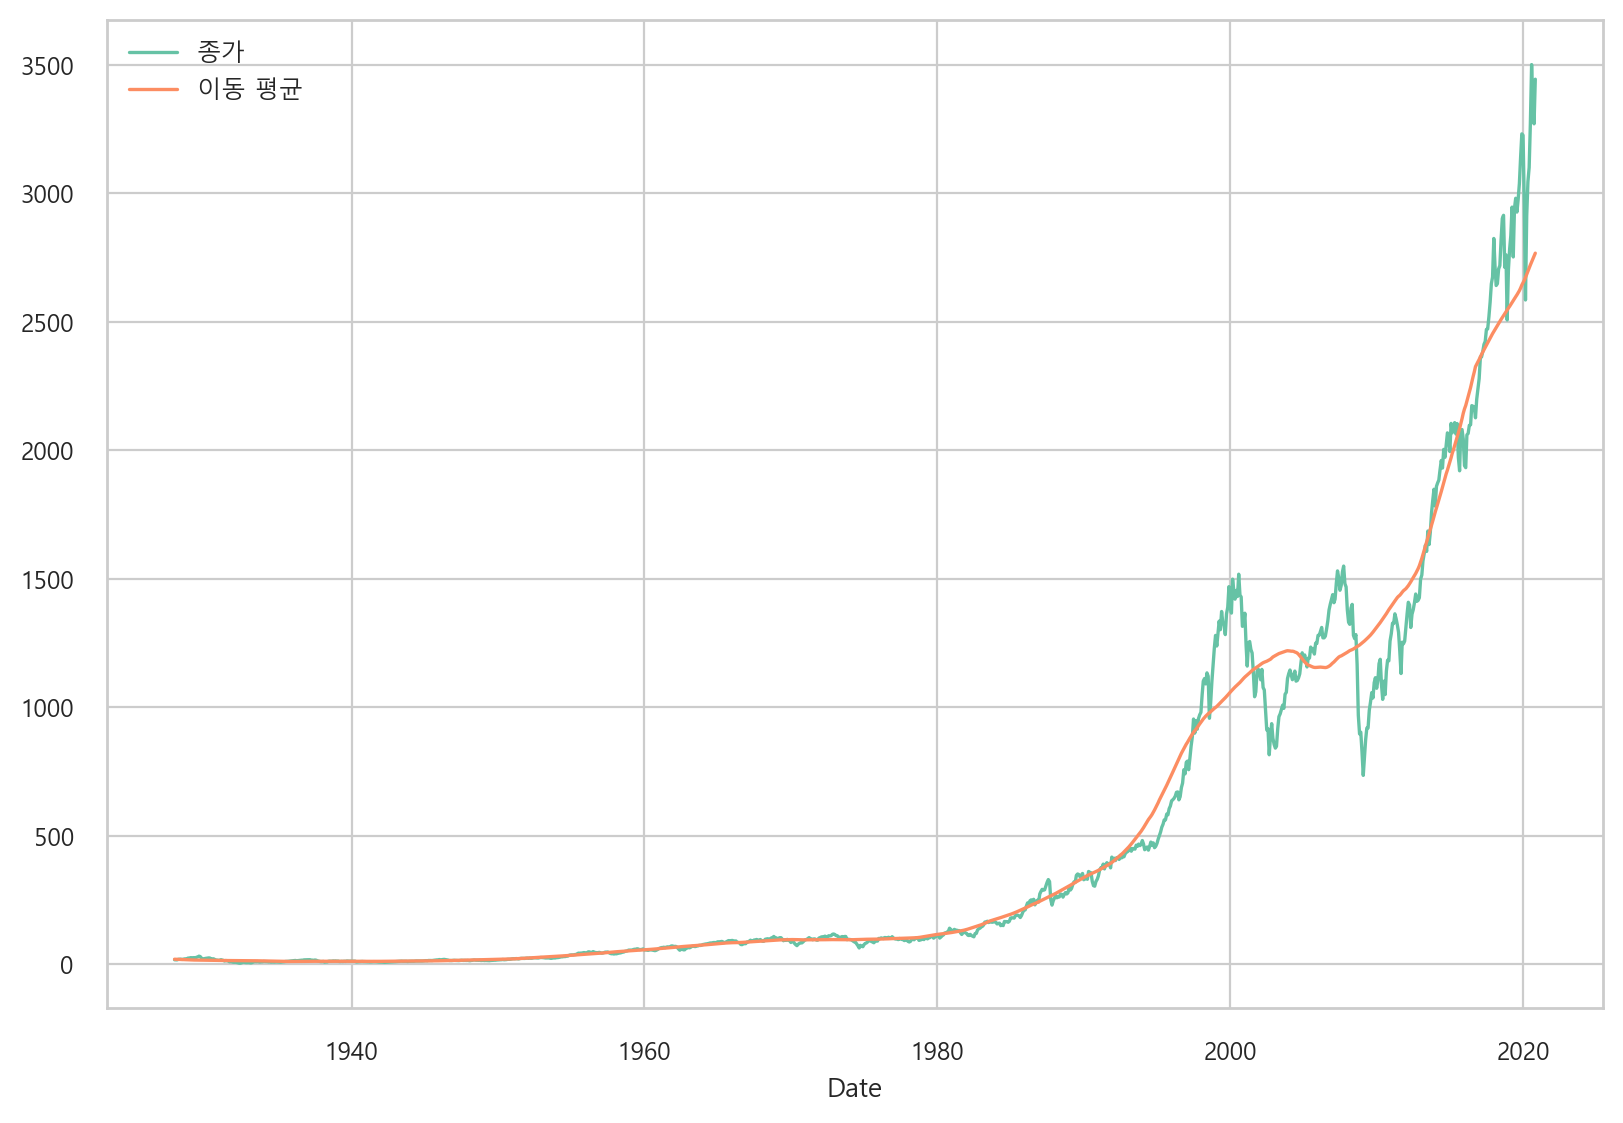

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(x = trend_500.index.astype("datetime64"),
             y = trend_500.values,
             label = "종가")

sns.lineplot(x = trend_500_trend.index.astype("datetime64"),
             y = trend_500_trend.values,
             label = "이동 평균")

In [ ]:
X = snp_500_month_end[['time']] # ex) 1, 2, 3 ,...
y = trend_500_trend # 각 시간별 추세

In [ ]:
# 다항 특성 생성
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
np.int64(X_poly)

'\narray([[      1,       0,       0],\n       [      1,       1,       1],\n       [      1,       2,       4],\n       ...,\n       [      1,    1113, 1238769],\n       [      1,    1114, 1240996],\n       [      1,    1115, 1243225]], dtype=int64)\n'

<AxesSubplot: xlabel='Date'>

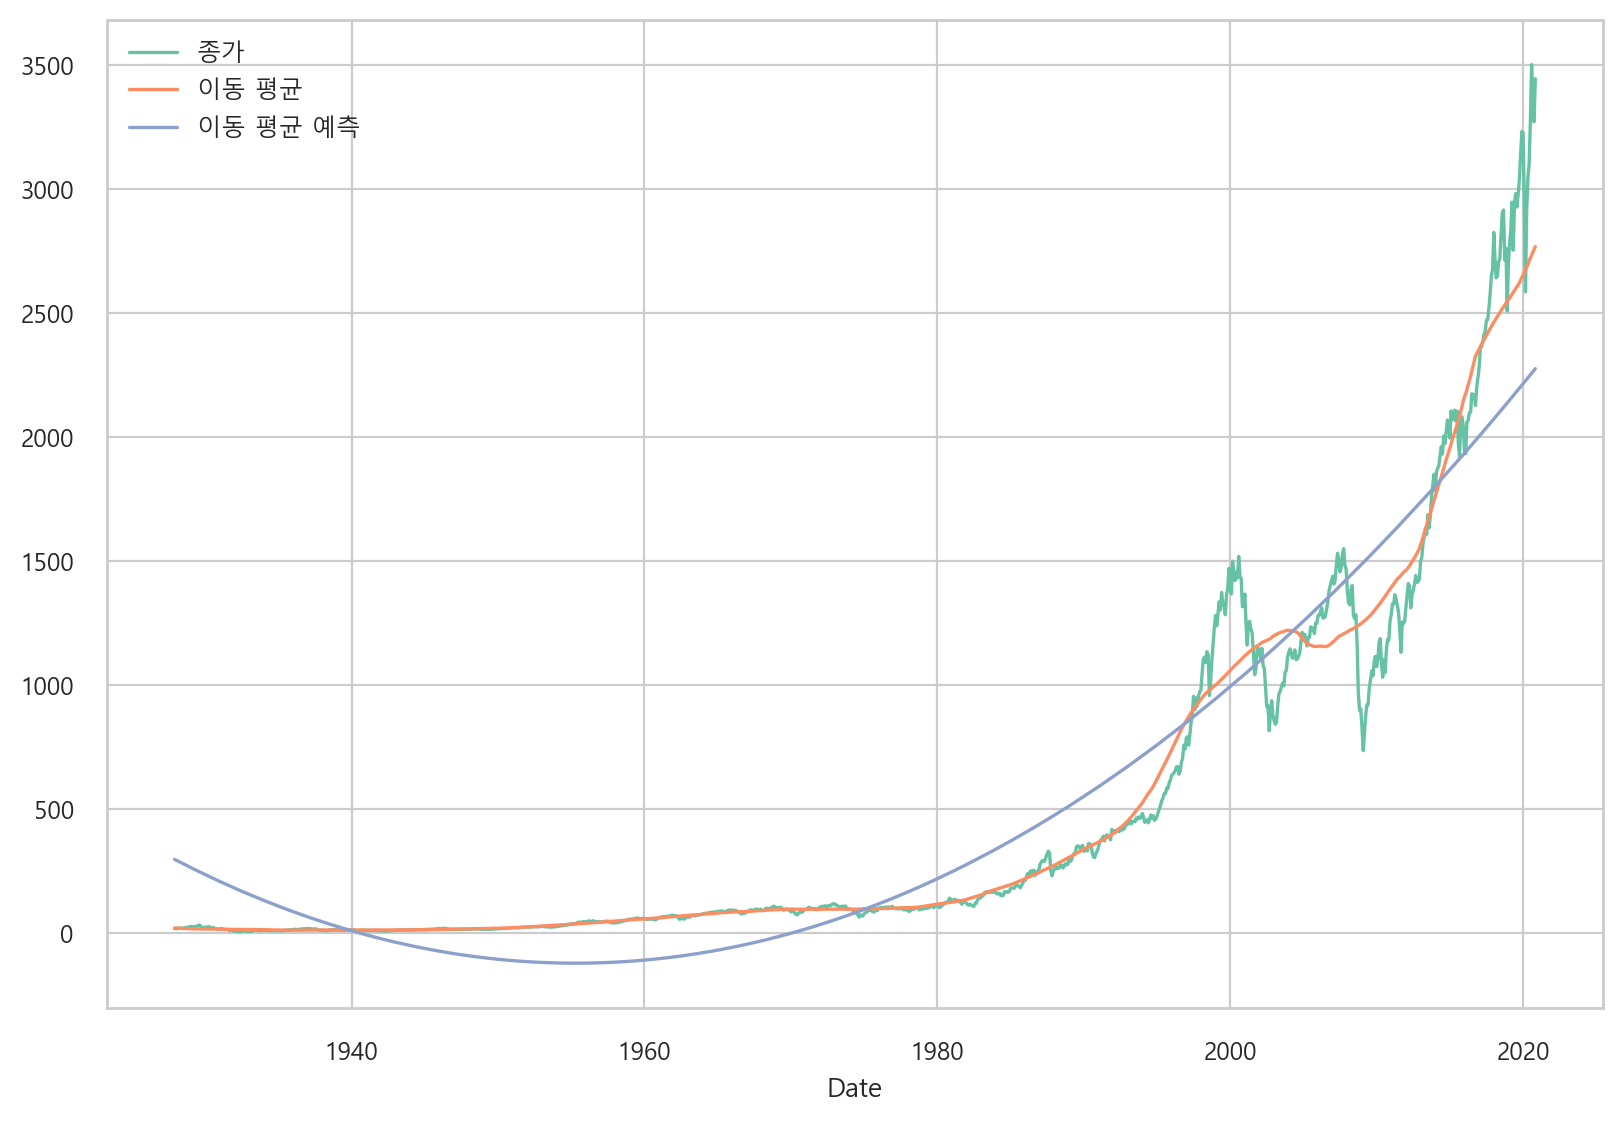

In [ ]:

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_poly, y)

# 예측
pred = model.predict(X_poly)

# 결과 플롯팅
fig, ax = plt.subplots()

sns.lineplot(x = trend_500.index.astype("datetime64"),
             y = trend_500.values,
             label = "종가")

sns.lineplot(x = trend_500.index.astype("datetime64"),
             y = trend_500_trend.values,
             label = "이동 평균")


sns.lineplot(x = trend_500.index.astype("datetime64"),
             y = pred,
             label='이동 평균 예측')


In [ ]:
dict_date_afterword = {}
for i in range(1, 121): # 추가로 10년간 데이터
    dict_date_afterword[X.index[-1] + i] = int(X.iloc[-1]) + i

df_after = pd.DataFrame(data=dict_date_afterword.values(),
                        index=dict_date_afterword.keys(),
                        columns=["time"])

NameError: name 'make_polys' is not defined

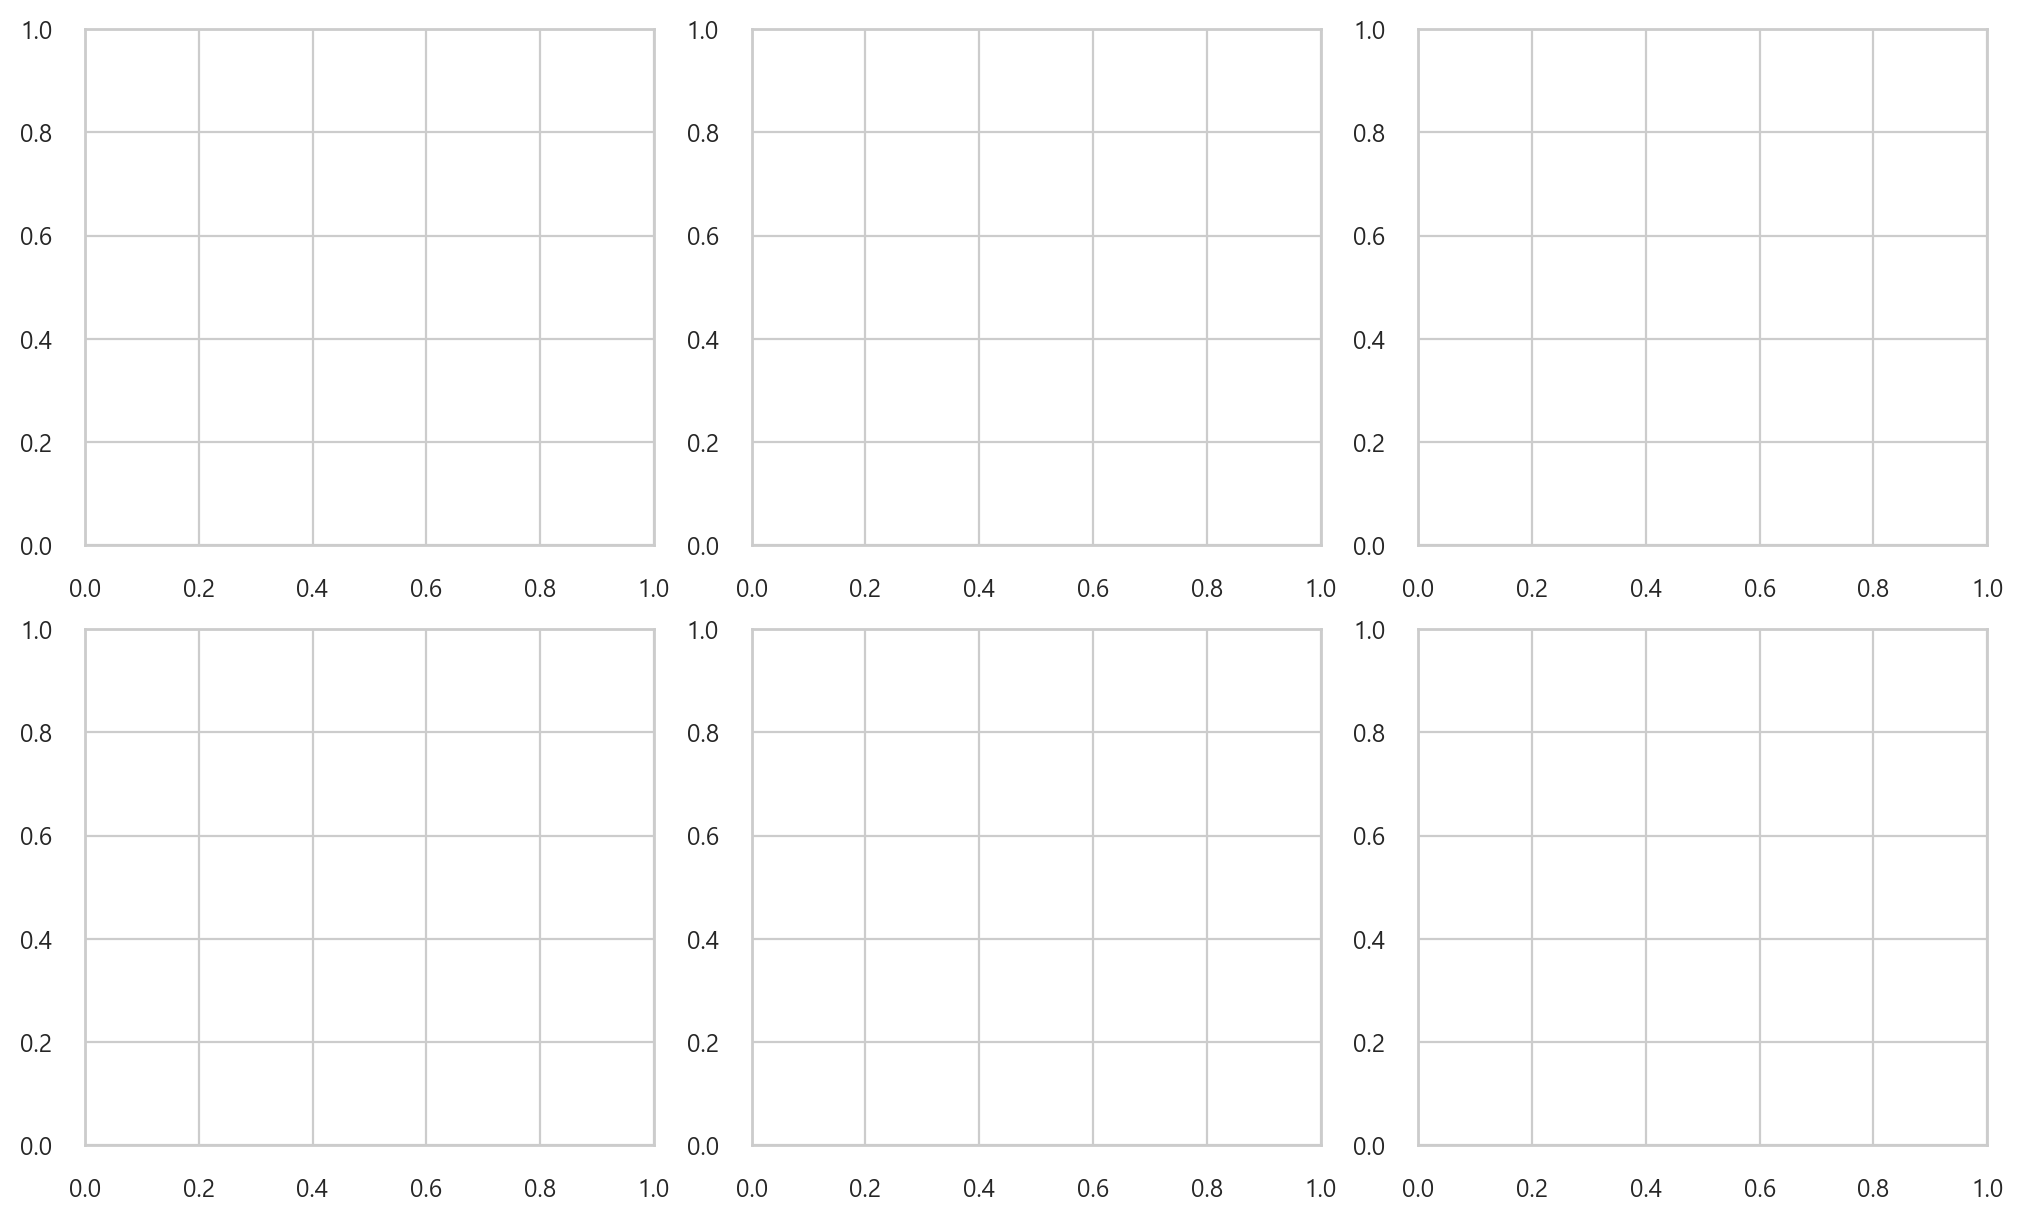

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(10,6))
ind_list = [[j,k] for k in range(3) for j in range(2)]

for i in range(1,7):
    model = LinearRegression()
    model.fit(make_polys(X,i), y)
    pred = model.predict(make_polys(X,i))
    pred_after = model.predict(make_polys(df_after,i))

    r = ind_list[i-1][0]
    c = ind_list[i-1][1]
    

    sns.lineplot(x = trend_500.index.astype("datetime64"),
                 y = trend_500.values,
                 alpha = 0.3,
                 label = "종가",
                 ax=ax[r][c])
    sns.lineplot(x = trend_500.index.astype("datetime64"),
                 y = trend_500_trend.values,
                 alpha = 0.3,
                 label = "이동 평균",
                 ax=ax[r][c])
    sns.lineplot(x = trend_500.index.astype("datetime64"),
                y = pred,
                label=f'이동 평균 예측(다항 식 갯수 {i})',
                ax=ax[r][c])
    sns.lineplot(x = df_after.index.astype("datetime64"),
                y = pred_after,
                label=f'이후의 예측',
                ax=ax[r][c])


In [ ]:
snp_500 = pd.read_csv('../datas/study_data/snp500_history.csv',
                      index_col='Date',
                      parse_dates=['Date'])

snp_500_month_end = snp_500.resample('M').last()

snp_500_month_end.index = snp_500_month_end.index.to_period()
snp_500_month_end['time'] = np.arange(len(snp_500_month_end.index))


trend_500 = snp_500_month_end["Adj Close"]
# 추세 구하는 함수
trend_500_trend = snp_500_month_end["Adj Close"].rolling(
    window=100,
    center=True,
    min_periods=6,
).mean()

In [ ]:
test = snp_500_month_end[["Adj Close"]].tail(10).copy()
test["trend"] = test.rolling(window=5,center=True,).mean()
test

,Adj Close,trend
Date,,
2020-02,2954.219971,NaN
2020-03,2584.590088,NaN
2020-04,2912.429932,2919.168018
2020-05,3044.310059,2982.548047
2020-06,3100.290039,3165.692041
2020-07,3271.120117,3255.806055
2020-08,3500.310059,3300.936035
2020-09,3363.000000,3369.566016
2020-10,3269.959961,NaN


<AxesSubplot: xlabel='Date'>

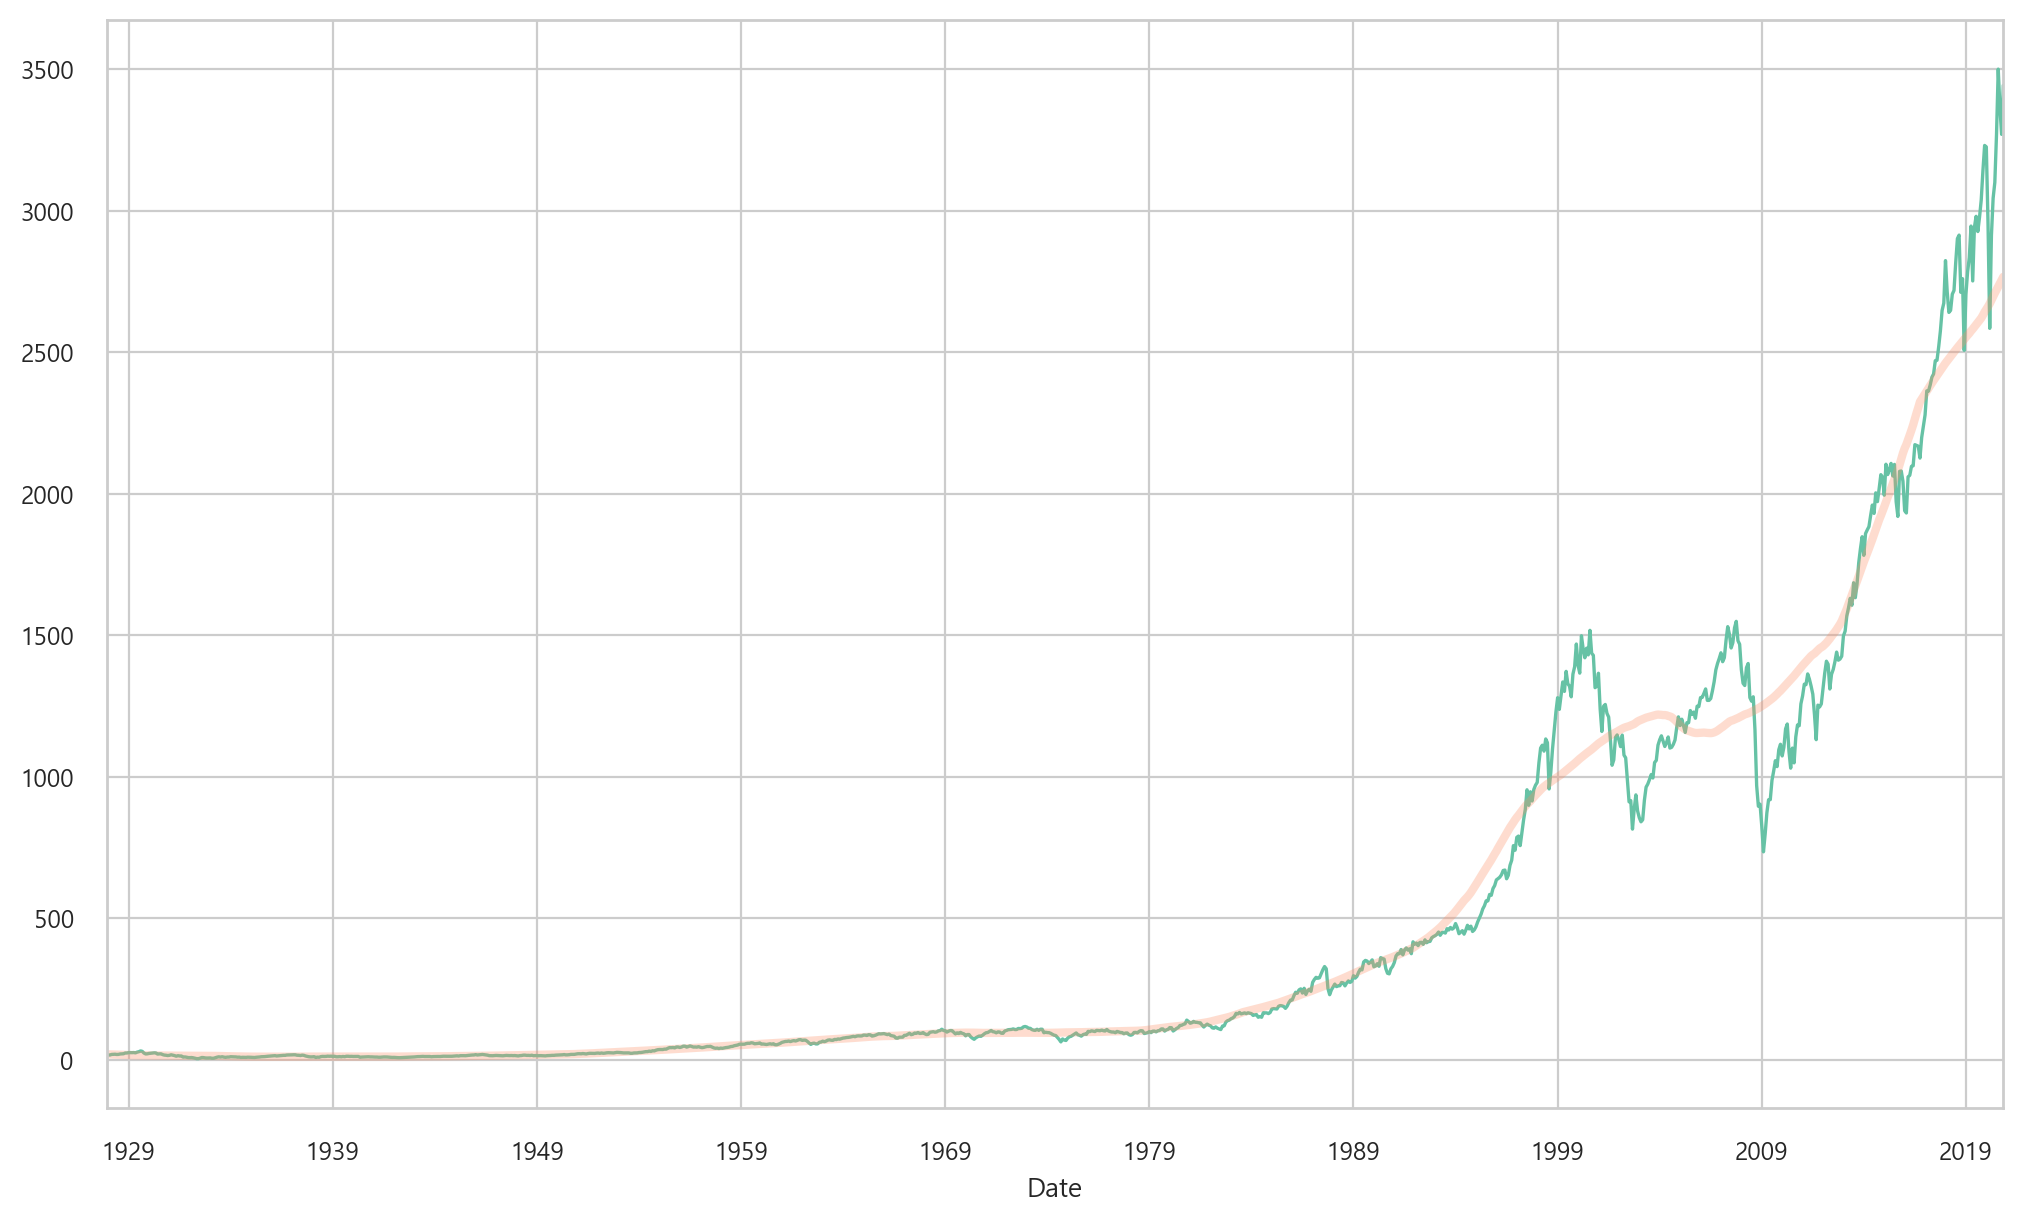

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

trend_500.plot(ax=ax)
trend_500_trend.plot(ax=ax, linewidth = 3, alpha = 0.3)

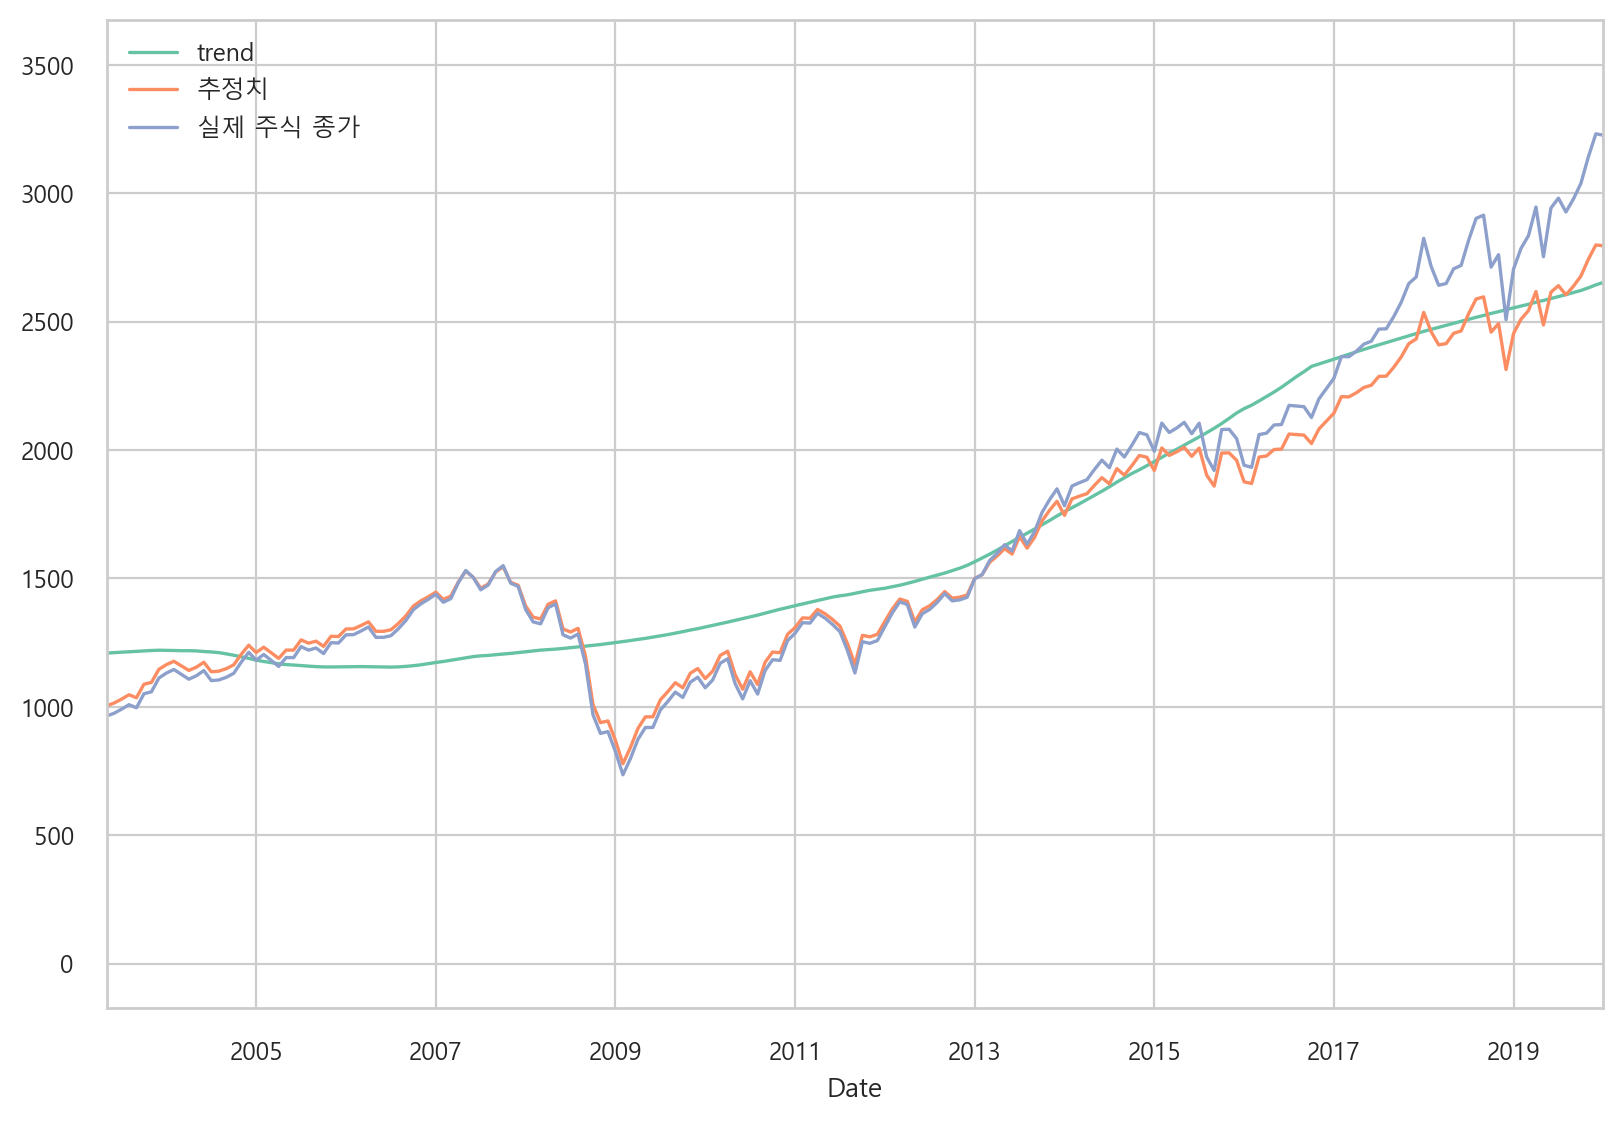

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = pd.DataFrame(trend_500).copy()
y = pd.Series(trend_500_trend).copy() 
y.name = "trend"

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict using the model
pred = model.predict(X_poly)

# Plot the predictions
fig, ax = plt.subplots()

y.plot(ax = ax) # 이동 평균선
ax.plot(y.index,pred, label='추정치') 
ax.plot(y.index,X,label='실제 주식 종가')
ax.set(xlim=[400,600])#, ylim=[75,300])
ax.legend();

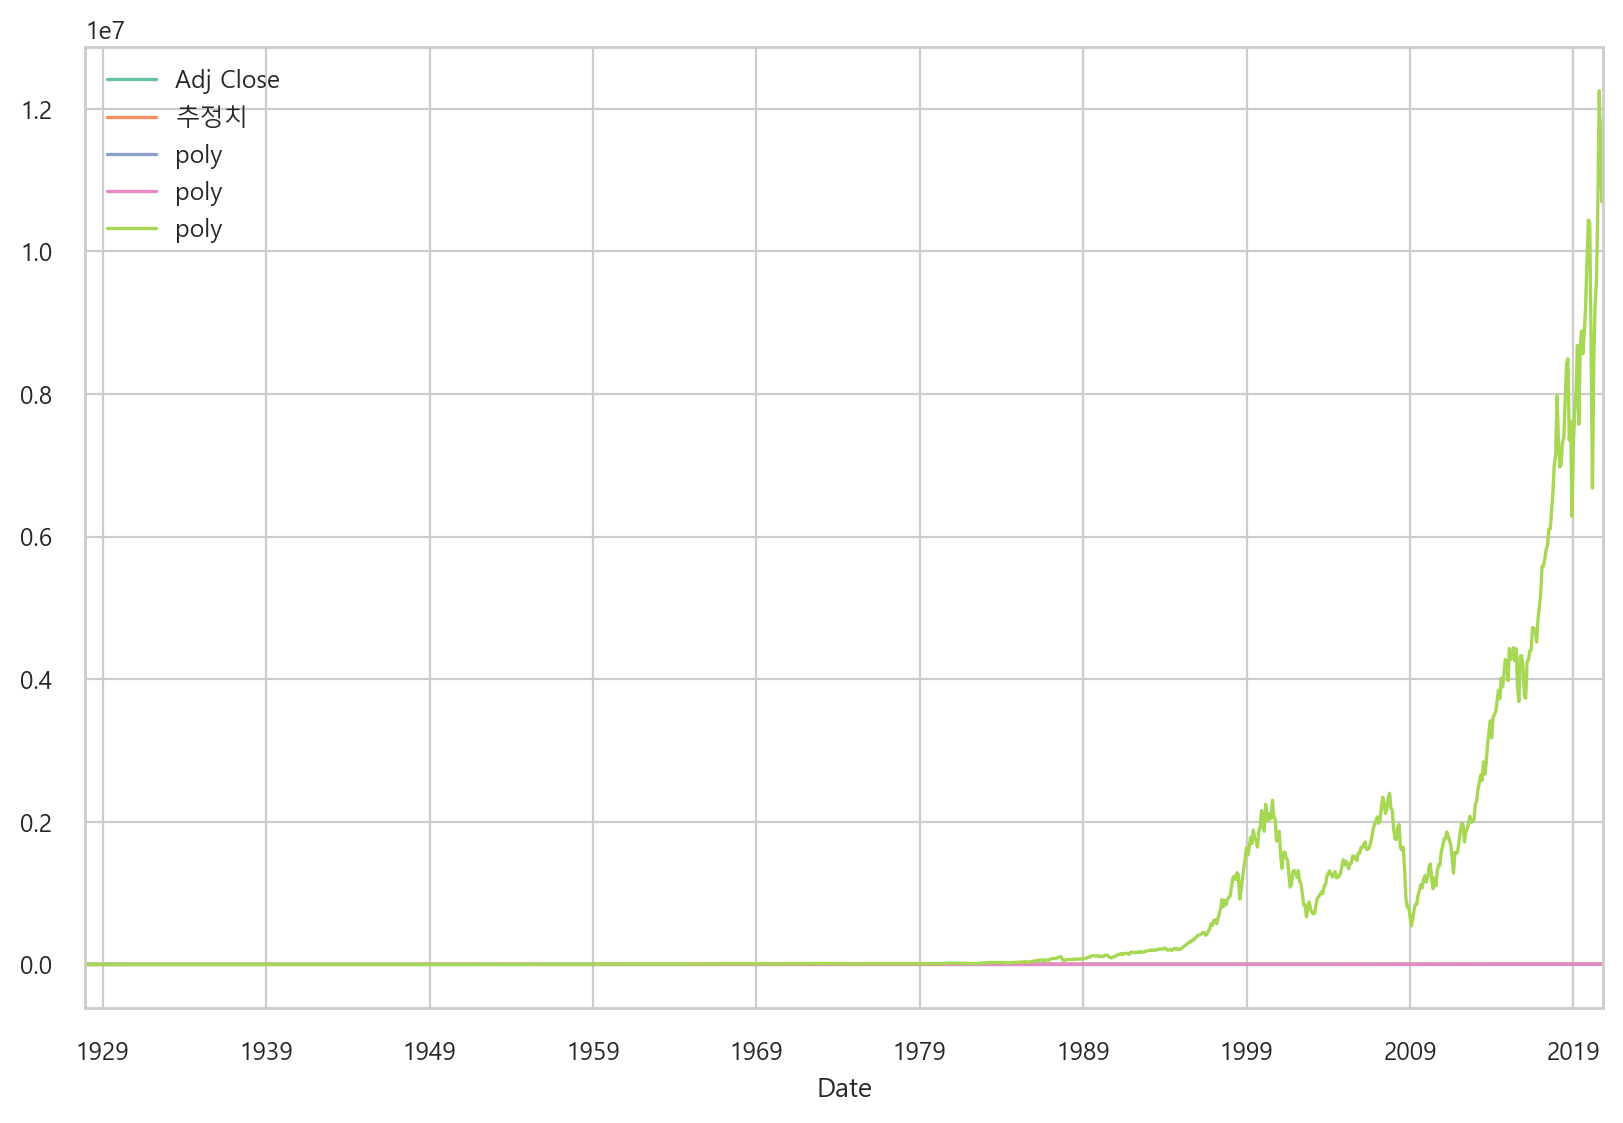

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = pd.DataFrame(trend_500).copy()
y = pd.DataFrame(trend_500_trend).copy() 
y.name = "trend"

# Create polynomial features
poly = PolynomialFeatures(degree=2)
y_poly = poly.fit_transform(y)

# Fit a linear regression model
model = LinearRegression()
model.fit(y_poly, y)

# Predict using the model
pred = model.predict(X_poly)

# Plot the predictions
fig, ax = plt.subplots()

y.plot(ax = ax) # 이동 평균선
ax.plot(y.index,pred, label='추정치') 
ax.plot(y.index,X_poly,label='poly')
# ax.set(xlim=[400,600])#, ylim=[75,300])
ax.legend();

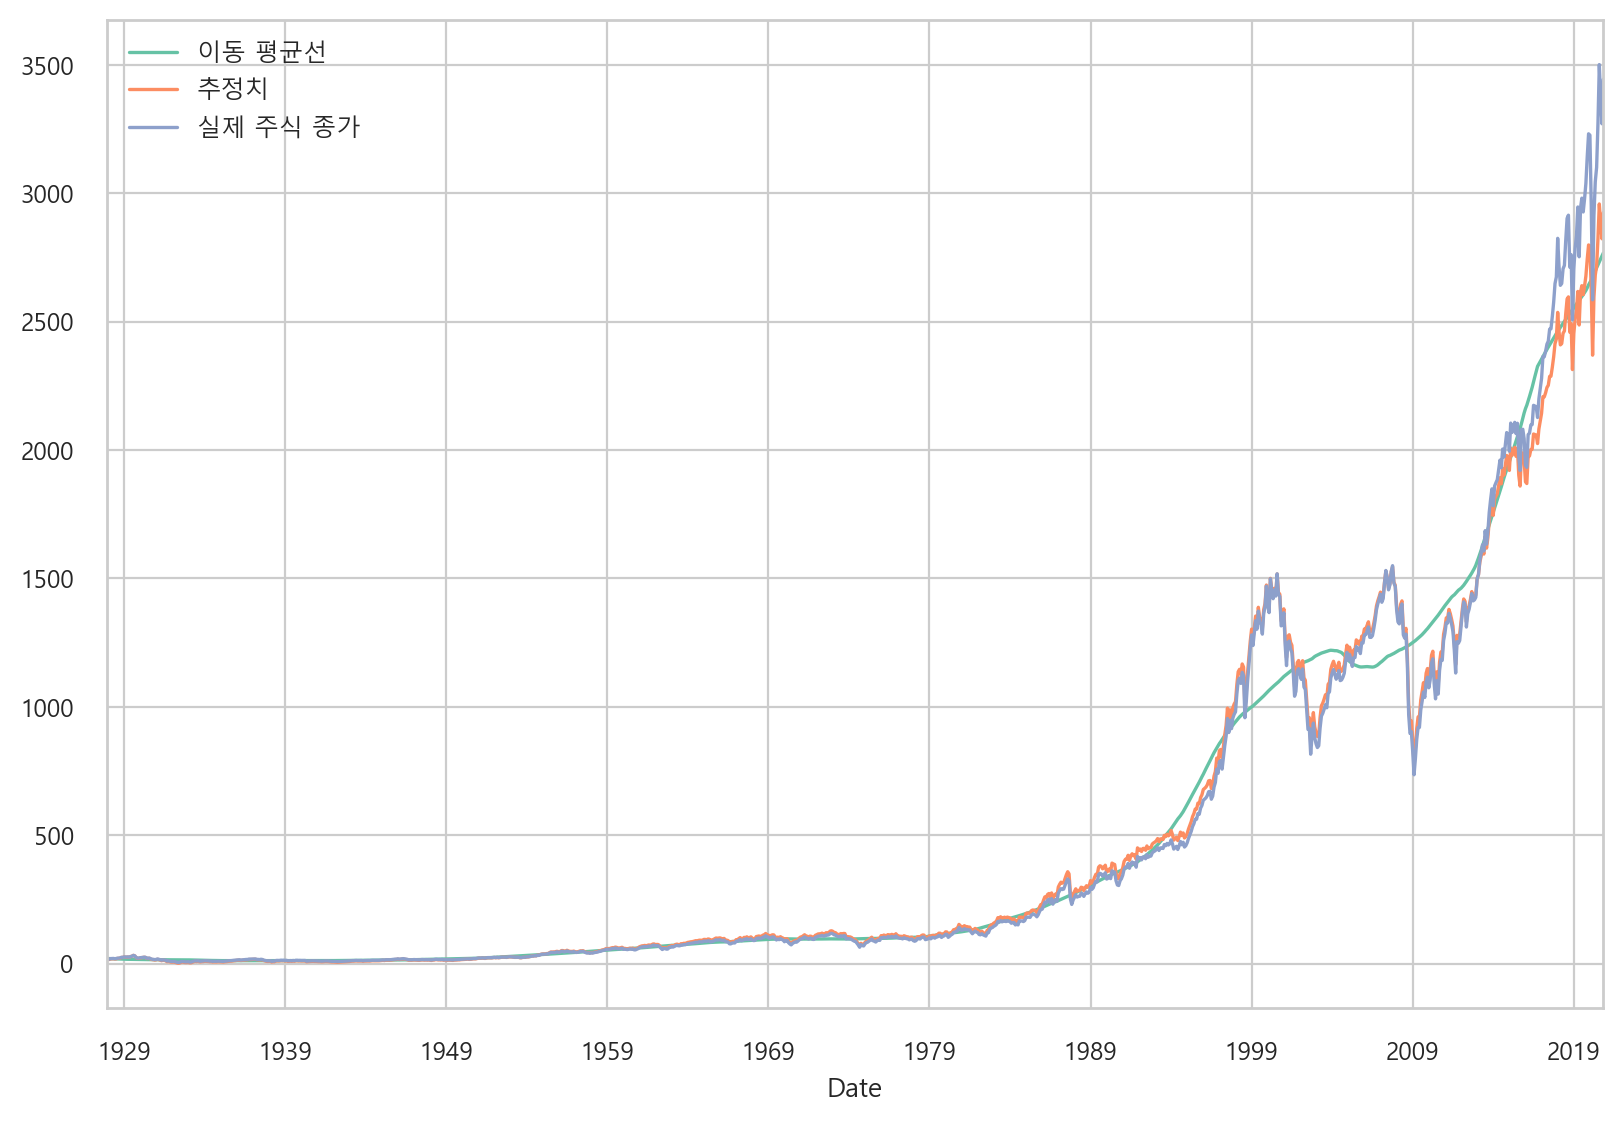

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 데이터 불러오기
snp_500 = pd.read_csv('../datas/study_data/snp500_history.csv',
                      index_col='Date',
                      parse_dates=['Date'])

# 월말 데이터로 리샘플링
snp_500_month_end = snp_500.resample('M').last()

# 인덱스를 기간으로 변환
snp_500_month_end.index = snp_500_month_end.index.to_period('M')
snp_500_month_end['time'] = np.arange(len(snp_500_month_end.index))

# 이동 평균 구하기
trend_500 = snp_500_month_end["Adj Close"]
trend_500_trend = trend_500.rolling(window=100, center=True, min_periods=6).mean()

# 데이터 준비
X = pd.DataFrame(trend_500)
y = trend_500_trend

# 결측치 제거
X = X.dropna()
y = y.dropna()

# 다항 특성 생성
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_poly, y)

# 예측
pred = model.predict(X_poly)

# 결과 플롯팅
fig, ax = plt.subplots()

y.plot(ax=ax, label='이동 평균선')  # 이동 평균선
ax.plot(y.index, pred, label='추정치')  # 추정치
ax.plot(X.index, X, label='실제 주식 종가')  # 실제 종가
ax.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 데이터 불러오기
snp_500 = pd.read_csv('../datas/study_data/snp500_history.csv',
                      index_col='Date',
                      parse_dates=['Date'])

In [ ]:

# 월말 데이터로 리샘플링
snp_500_month_end = snp_500.resample('M').last()

In [ ]:

# 인덱스를 기간으로 변환
snp_500_month_end.index = snp_500_month_end.index.to_period('M')
snp_500_month_end['time'] = np.arange(len(snp_500_month_end.index))

<AxesSubplot: xlabel='Date'>

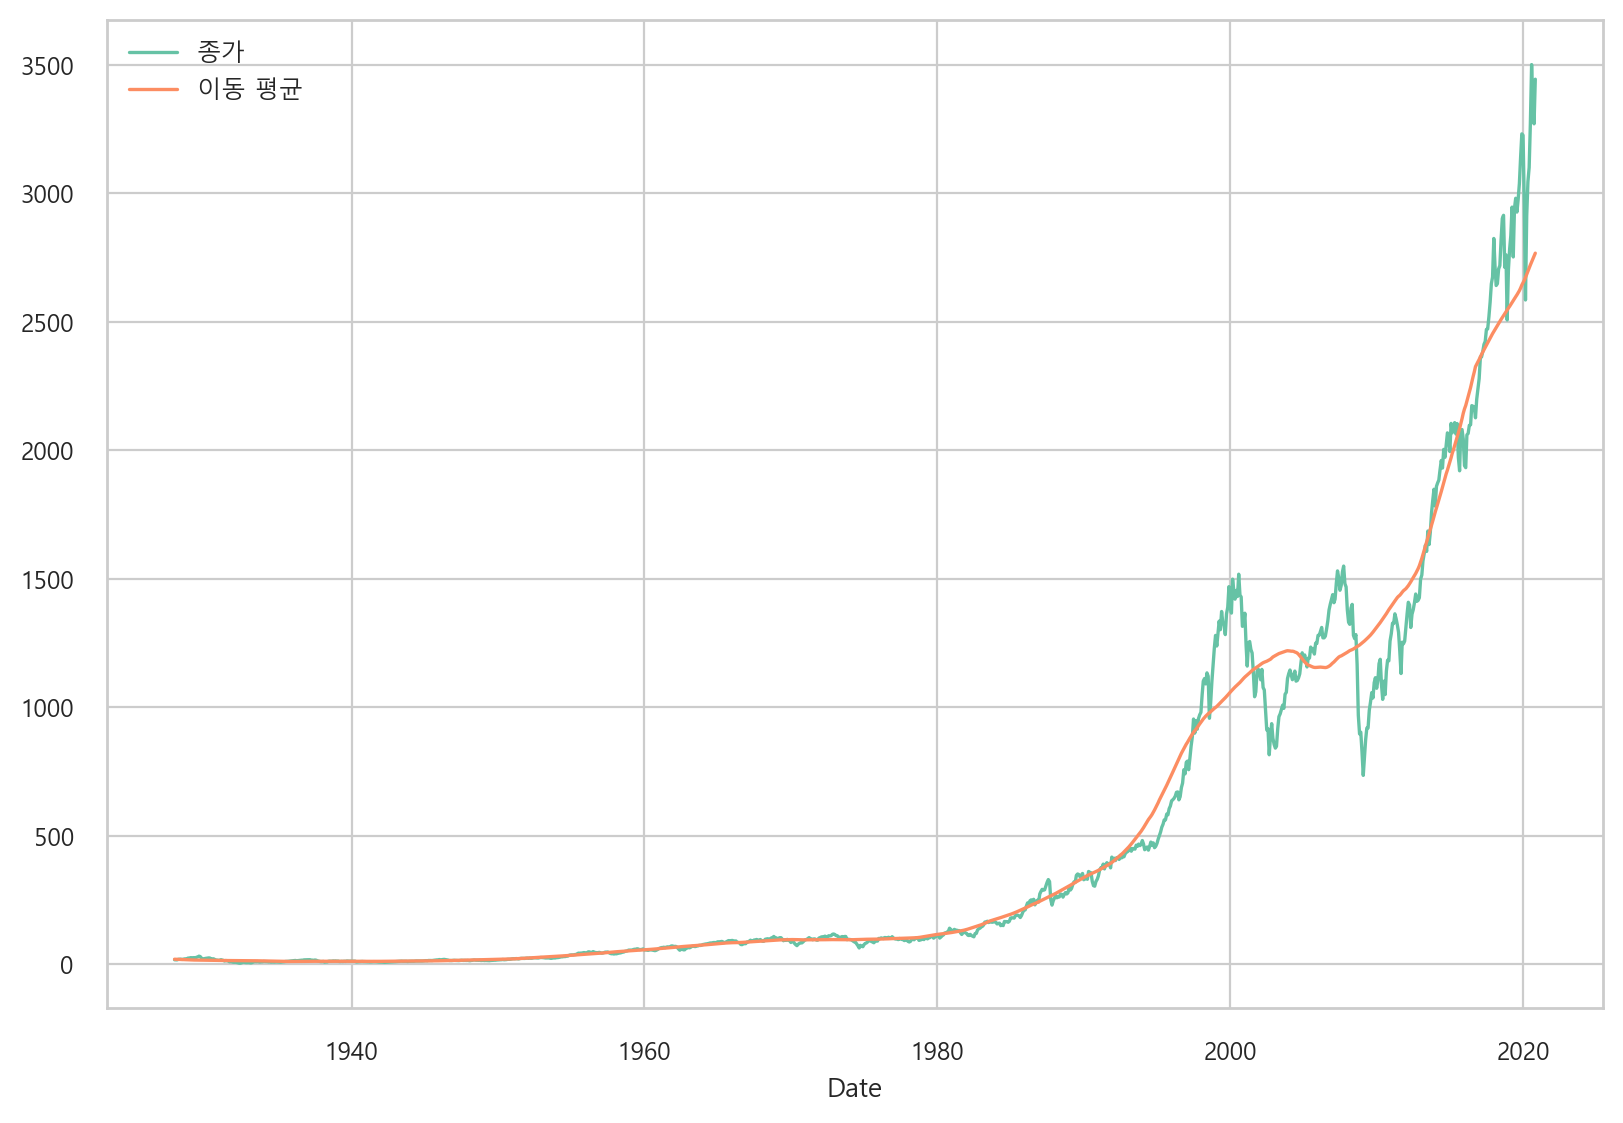

In [ ]:

# 이동 평균 구하기
trend_500 = snp_500_month_end["Adj Close"]
trend_500_trend = trend_500.rolling(window=100, center=True, min_periods=6).mean()

fig, ax = plt.subplots()

sns.lineplot(x = trend_500.index.astype("datetime64"),
             y = trend_500.values,
             label = "종가")

sns.lineplot(x = trend_500_trend.index.astype("datetime64"),
             y = trend_500_trend.values,
             label = "이동 평균")

In [ ]:

# 독립 변수와 종속 변수 설정
X = snp_500_month_end[['time']]
y = trend_500_trend

X = [0, 1, 2, 3, 4]
degree 가 1 인경우
X_ploy = [[1,0], [1,1], [1,2], [1,3], [1,4]]
degree 가 2 인경우
X_ploy = [[1,0,0], [1,1,1], [1,2,4], [1,3,9], [1,4,16]] ...

즉 다항 특성은 [1,x,x^2,x^3 ...]

In [ ]:
def make_polys(X,degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    return X_poly

dict_date_afterword = {}
for i in range(1, 121): # 추가로 10년간 데이터
    dict_date_afterword[X.index[-1] + i] = int(X.iloc[-1]) + i

df_after = pd.DataFrame(data=dict_date_afterword.values(),
                        index=dict_date_afterword.keys(),
                        columns=["time"])
                    

# 새로운 날짜 생성
new_dates = pd.date_range(start=X.index[-1], periods=100, freq='D')

# 새로운 날짜에 해당하는 값 계산
new_values = pd.Series(range(int(X.iloc[-1]), int(X.iloc[-1]) + 100), index=new_dates)

# DataFrame 생성
df_after = pd.DataFrame({'time': new_values})


In [ ]:
# # 결과 플롯팅
# df_after

# # 선형 회귀 모델 학습
# for i in range(1,6):
    
#     model = LinearRegression()
#     model.fit(make_polys(X,i), y)
#     pred = model.predict(make_polys(X,i))
#     pred_after = model.predict(make_polys(df_after,i))

#     fig, ax = plt.subplots()

#     sns.lineplot(x = trend_500.index.astype("datetime64"),
#                  y = trend_500.values,
#                  alpha = 0.3,
#                  label = "종가")

#     sns.lineplot(x = trend_500.index.astype("datetime64"),
#                  y = trend_500_trend.values,
#                  alpha = 0.3,
#                  label = "이동 평균")
#     sns.lineplot(x = trend_500.index.astype("datetime64"),
#              y = pred,
#              label=f'이동 평균 예측(다항 식 갯수 {i})')
    
#     sns.lineplot(x = df_after.index.astype("datetime64"),
#              y = pred_after,
#              label=f'이후의 예측')
    


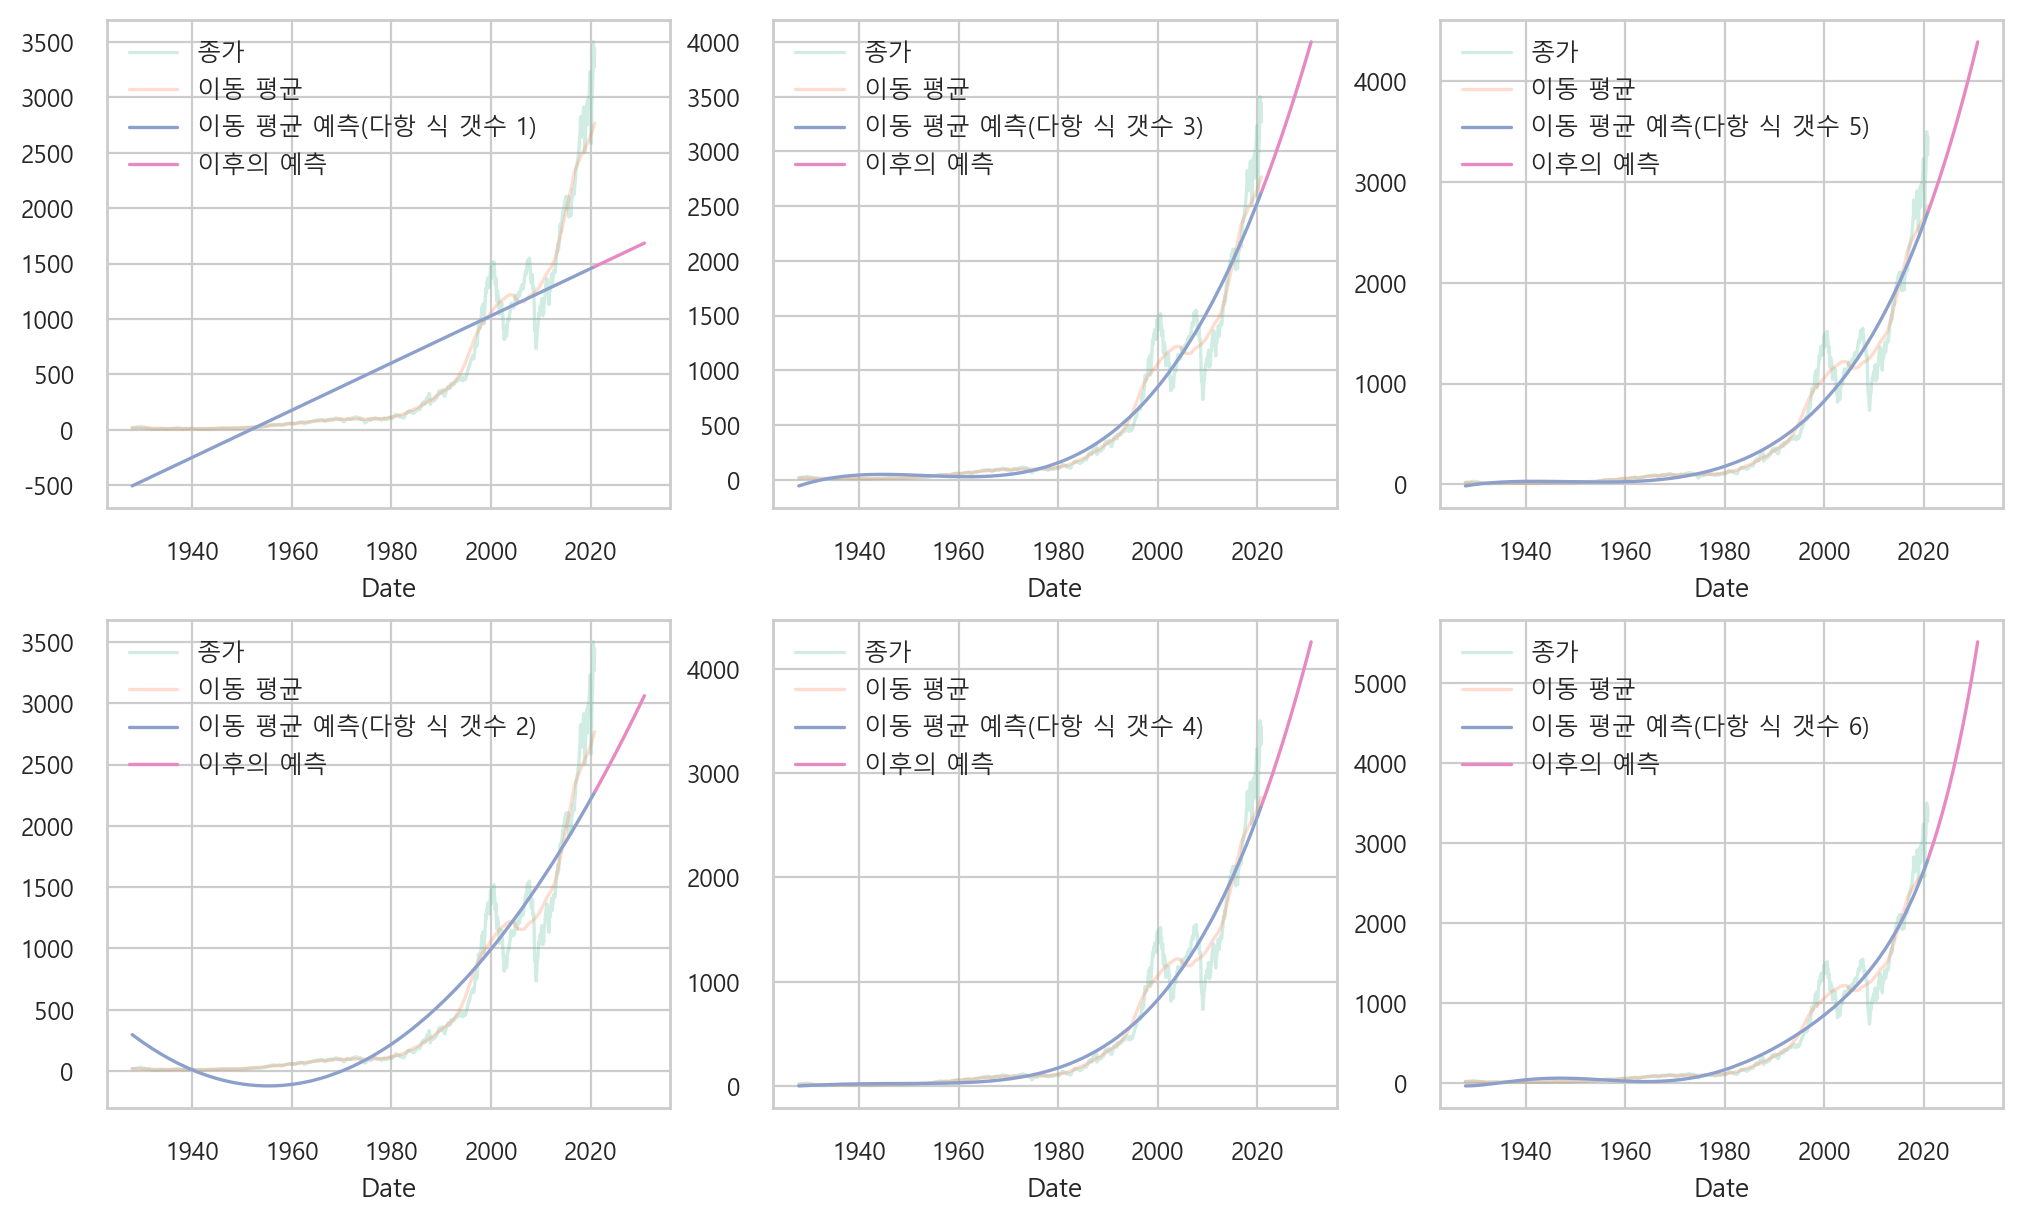

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(10,6))
ind_list = [[j,k] for k in range(3) for j in range(2)]

for i in range(1,7):
    model = LinearRegression()
    model.fit(make_polys(X,i), y)
    pred = model.predict(make_polys(X,i))
    pred_after = model.predict(make_polys(df_after,i))

    r = ind_list[i-1][0]
    c = ind_list[i-1][1]
    

    sns.lineplot(x = trend_500.index.astype("datetime64"),
                 y = trend_500.values,
                 alpha = 0.3,
                 label = "종가",
                 ax=ax[r][c])
    sns.lineplot(x = trend_500.index.astype("datetime64"),
                 y = trend_500_trend.values,
                 alpha = 0.3,
                 label = "이동 평균",
                 ax=ax[r][c])
    sns.lineplot(x = trend_500.index.astype("datetime64"),
                y = pred,
                label=f'이동 평균 예측(다항 식 갯수 {i})',
                ax=ax[r][c])
    sns.lineplot(x = df_after.index.astype("datetime64"),
                y = pred_after,
                label=f'이후의 예측',
                ax=ax[r][c])


NameError: name 'make_polys' is not defined

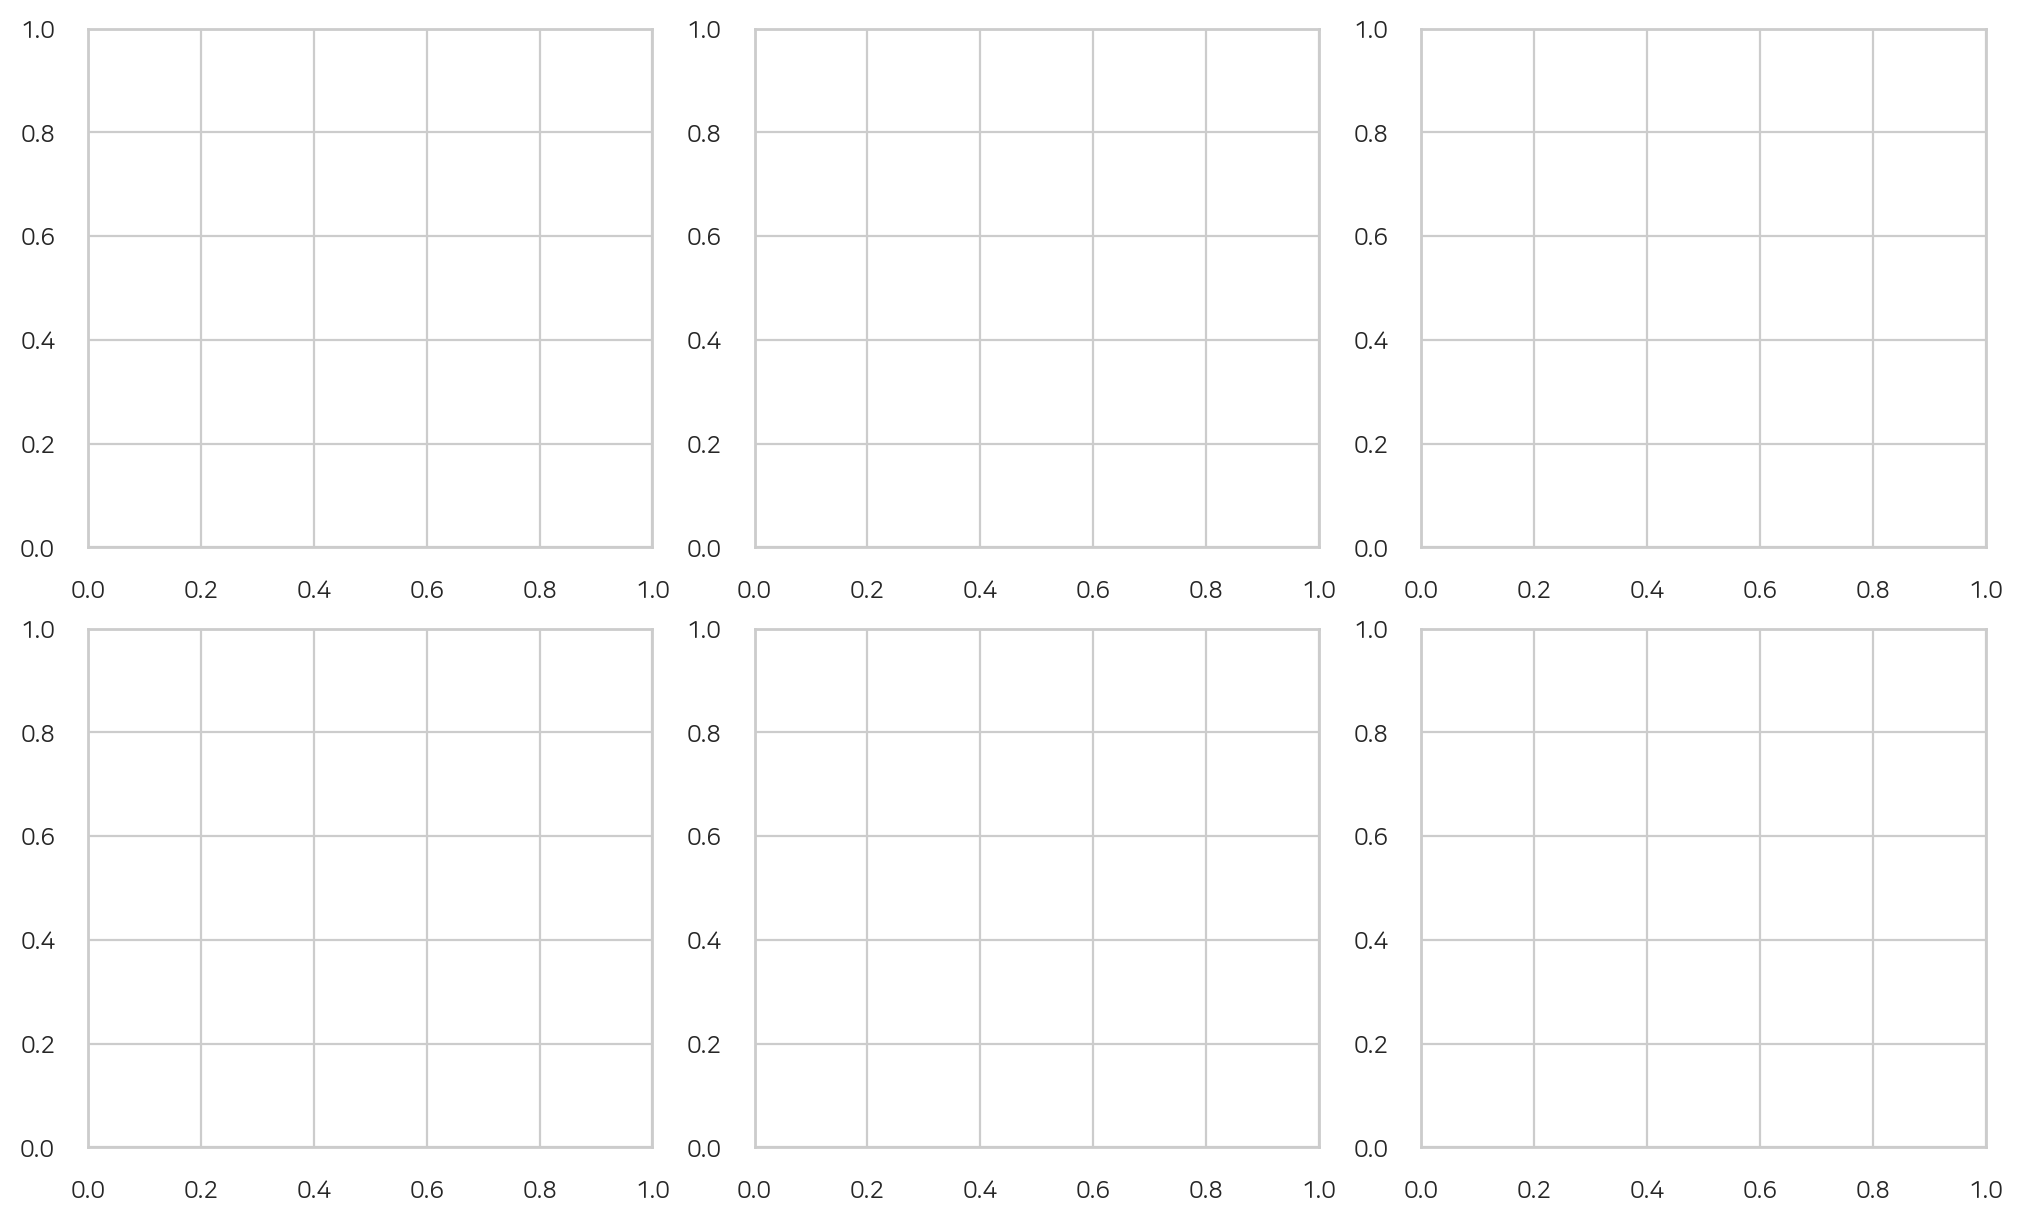

In [62]:
fig, ax = plt.subplots(2,3,figsize=(10,6))
ind_list = [[j,k] for k in range(3) for j in range(2)]

for i in range(1,7):
    model = LinearRegression()
    model.fit(make_polys(X,i), y)
    pred = model.predict(make_polys(X,i))

    r = ind_list[i-1][0]
    c = ind_list[i-1][1]
    

    sns.lineplot(x = trend_500.index.astype("datetime64"),
                 y = trend_500.values,
                 alpha = 0.3,
                 label = "종가",
                 ax=ax[r][c])
    sns.lineplot(x = trend_500.index.astype("datetime64"),
                 y = trend_500_trend.values,
                 alpha = 0.3,
                 label = "이동 평균",
                 ax=ax[r][c])
    sns.lineplot(x = trend_500.index.astype("datetime64"),
             y = pred,
             label=f'이동 평균 예측(다항 식 갯수 {i})',
                 ax=ax[r][c])
plt.tight_layout()